# Exploration of Madrid's rental market 
## Airbnb price prediction with Machine Learning.


### 1. Project background and aim

 Airbnb is a internet marketplace for short-term home and apartment rentals. It allows you to, for example, rent out your home for a week while you’re away, or rent out your empty bedroom. One challenge that Airbnb hosts face is determining the optimal nightly rent price. In many areas, renters are presented with a good selection of listings and can filter by criteria like price, number of bedrooms, room type, and more. Since Airbnb is a market, the amount a host can charge is ultimately tied to market prices. The search experience on Airbnb looks like this: 
 
One method could be to find a few listings that are similar to the place that will be up for rent, average the listed prices and set our price to this calculated average price. However, with the market being so dynamic, we would probably be looking to update the price regularly and this method can become tedious. 

Moreover, this may not be very accurate, as we are not taking into account other important factors that may give us a comparative advantage over other listings around us. This could be property characteristics such as number of rooms, bathrooms and extra services on offer. 

The aim of this project is to propose a data-driven solution, by using machine learning to predict rental price.

For this project, a predictor based on space will be introduced to the model: the property's proximity to certain venues. This will allow the model to put an implicit price on things such as living close to a bar or a supermarket.

### 2. Data Description

Some of the more important features this project will look into are the following: 

- `accommodates`: the number of guests the rental can accommodate
- `bedrooms`: number of bedrooms included in the rental
- `bathrooms`: number of bathrooms included in the rental
- `beds`: number of beds included in the rental
- `price`: nightly price for the rental
- `minimum_nights`: minimum number of nights a guest can stay for the rental
- `maximum_nights`: maximum number of nights a guest can stay for the rental
- `number_of_reviews`: number of reviews that previous guests have left


#### Install required packages

In [1]:
# general required packages
# %load basic_installs.py
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install mplleaflet
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install geocoder
!{sys.executable} -m pip install geopy
!{sys.executable} -m pip install folium
!{sys.executable} -m pip install lxml
!{sys.executable} -m pip install pygeoj
!{sys.executable} -m pip install pyshp
!{sys.executable} -m pip install datetime
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install --upgrade cython

In [2]:
# required package for timeseries
!{sys.executable} -m pip install statsmodels

In [3]:
# requiered package to run geopandas
!conda install -c conda-forge libspatialindex -y

Solving environment: ...working... done

# All requested packages already installed.



In [4]:
# required packages for neighbourhood analysis
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install descartes
!{sys.executable} -m pip install requests

In [5]:
# requiered packages for accessibility analysis
# Make sure Cython is upgraded FIRST!
!{sys.executable} -m pip install pandana

In [6]:
# requiered packages for modelling
!{sys.executable} -m pip install xgboost

In [7]:
%matplotlib inline

# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os 
# Geographical analysis
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import shapefile as shp
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import descartes

# accessibility analysis
import time
from pandana.loaders import osm
from pandana.loaders import pandash5

# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

#Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Set plot preference
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

print('Libraries imported.')

Libraries imported.


In [8]:
import geopandas as gpd

### 3. Cleaning and Pre-processing

In [9]:
#!pwd to check the working directory
raw_df = pd.read_csv('dataset_nuevo/listings_1.csv')
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 21495 Airbnb listings


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6369,https://www.airbnb.com/rooms/6369,20200110222856,2020-01-11,"Rooftop terrace room , ensuite bathroom",Excellent connection with the AIRPORT and EXHI...,BETTER THAN A HOTEL.Upscale neighboorhood (Met...,Excellent connection with the AIRPORT and EXHI...,none,Nice and definitely non touristic neighborhoo...,If you are a group/family 3 or 4 people we off...,Excelent public transport and easy Access to m...,"Full use of living room, kitchen (with dishwas...","English, spanish, german, russian, some french...",NaN,NaN,NaN,https://a0.muscache.com/im/pictures/683224/4cc...,NaN,13660,https://www.airbnb.com/users/show/13660,Simon,2009-04-16,"Madrid, Madrid, Spain","Gay couple, heterofriendly, enjoy having guest...",within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/1c793...,https://a0.muscache.com/im/pictures/user/1c793...,Hispanoamérica,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Madrid, Comunidad de Madrid, Spain",Chamartín,Hispanoamérica,Chamartín,Madrid,Comunidad de Madrid,28016,Madrid,"Madrid, Spain",ES,Spain,40.45628,-3.67763,t,Apartment,Private room,2,1.0,1.0,0.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,Elevator,Heat...",172.0,$70.00,$350.00,$950.00,$0.00,$5.00,2,$15.00,1,365,1,1,365,365,1.0,365.0,5 days ago,t,22,52,82,82,2020-01-11,73,14,2010-03-14,2019-12-13,98.0,10.0,10.0,10.0,10.0,9.0,10.0,t,NaN,NaN,f,f,flexible,f,f,1,0,1,0,0.61
1,21853,https://www.airbnb.com/rooms/21853,20200110222856,2020-01-11,Bright and airy room,We have a quiet and sunny room with a good vie...,I am living in a nice flat near the centre of ...,We have a quiet and sunny room with a good vie...,none,We live in a leafy neighbourhood with plenty o...,We are a 15 min bus ride away from the Casa de...,The flat is near the centre of Madrid (15 minu...,There is fibre optic internet connection for y...,If I am at home and see each other around here...,Gracias por no fumar en la casa. Es muy import...,NaN,NaN,https://a0.muscache.com/im/pictures/68483181/8...,NaN,83531,https://www.airbnb.com/users/show/83531,Abdel,2010-02-21,"Madrid, Madrid, Spain",EN-ES-FR\r\nEN\r\nHi everybody: I'm Abdel. I'm...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/83531/profile...,https://a0.muscache.com/im/users/83531/profile...,Aluch

#### Droping initial columns


Natural Language Processing will not be used in the creation of this model. Therefore, free text columns will be dropped for now, as will other columns which are not useful for predicting price (e.g. url, host name and other host-related features that are unrelated to the property).

In [10]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

Columns with several `NULL` entries are dropped too. 

In [11]:
df.isna().sum()

id                                                  0
experiences_offered                                 0
host_since                                         25
host_response_time                               4617
host_response_rate                               4617
host_acceptance_rate                            21495
host_is_superhost                                  25
host_listings_count                                25
host_total_listings_count                          25
host_has_profile_pic                               25
host_identity_verified                             25
street                                              0
neighbourhood                                     134
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                        0
city                                               10
state                                             376
zipcode                                           441
market                      

In [12]:
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 
         'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)

df.set_index('id', inplace=True) # ID as index

`host_listings_count` and `host_total_listings_count`These cases are those where the value is `NaN`. Therefore one of these columns can be dropped. Other columns which split these into type of property will also be dropped, as they will be highly correlated (one will be the total of the others).

In [13]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

25


,experiences_offered,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
163429,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Madrid, Madrid, Spain",Chamberí,Arapiles,Madrid,Madrid,28015,Madrid,"Madrid, Spain",ES,Spain,40.43628,-3.70526,t,Loft,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Buzzer/wireless int...",$65.00,$300.00,$40.00,1,$0.00,90,365,90,90,365,365,90.0,365.0,3 months ago,t,0,0,0,2,8,1,2011-08-03,2019-03-17,95.0,10.0,9.0,10.0,10.0,10.0,9.0,t,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.08
6899113,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Madrid, Comunidad de Madrid, Spain",Vallehermosa,Vallehermoso,Madrid,Comunidad de Madrid,28003,Madrid,"Madrid, Spain",ES,Spain,40.43917,-3.70674,t,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Smoking allowed"",""Pets...",$20.00,NaN,NaN,1,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,55 months ago,t,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,f,flexible,f,f,1,0,1,0,NaN
7712666,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Madrid, Comunidad de Madrid, Spain",Castillejos,Castillejos,Madrid,Comunidad de Madrid,28020,Madrid,"Madrid, Spain",ES,Spain,40.46295,-3.69036,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Air conditioning"",Kitchen,Doorman,Elevato...",$100.00,$300.00,NaN,1,$0.00,7,20,7,7,20,20,7.0,20.0,54 months ago,t,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,f,flexible,f,f,1,1,0,0,NaN
8963605,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Madrid, Comunidad de Madrid, Spain",Puente de Vallecas,San Diego,Madrid,Comunidad de Madrid,28053,Madrid,"Madrid, Spain",ES,Spain,40.39370,-3.66988,f,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Kitchen,Washer,Essentials,Shampoo}",$40.00,NaN,NaN,1,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,52 months ago,t,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,f,flexible,f,f,1,1,0,0,NaN
9206737,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Madrid, Comunidad de Madrid, Spain",Puente de Vallecas,San Diego,Madrid,Comunidad de Madrid,28018,Madrid,"Madrid, Spain",ES,Spain,40.38391,-3.66664,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",$35.00,NaN,NaN,2,$0.00,2,15,2,2,15,15,2.0,15.0,10 months ago,t,9,39,69,344,14,0,2015-12-09,2017-10-07,100.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,f,moderate,f,f,1,0,1,0,0.28


In [14]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 
         'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
         'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

There are multiple columns for property location, including an attempt by the site that originally scraped the data to clean up the neighbourhood locations. Some of these columns can be dropped. Because all of the listings are in Madrid, columns relating to city and country can be dropped. One column for area will be kept, `neighboorhood_cleansed`.

In [15]:
df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 
         'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. `minimum_nights` and `minimum_minimum_nights`. The latter presumably refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead.

In [16]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

2426

In [17]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
         'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

Checking whether boolean and categorical features contain sufficient numbers of instances in each category to make them worth including:

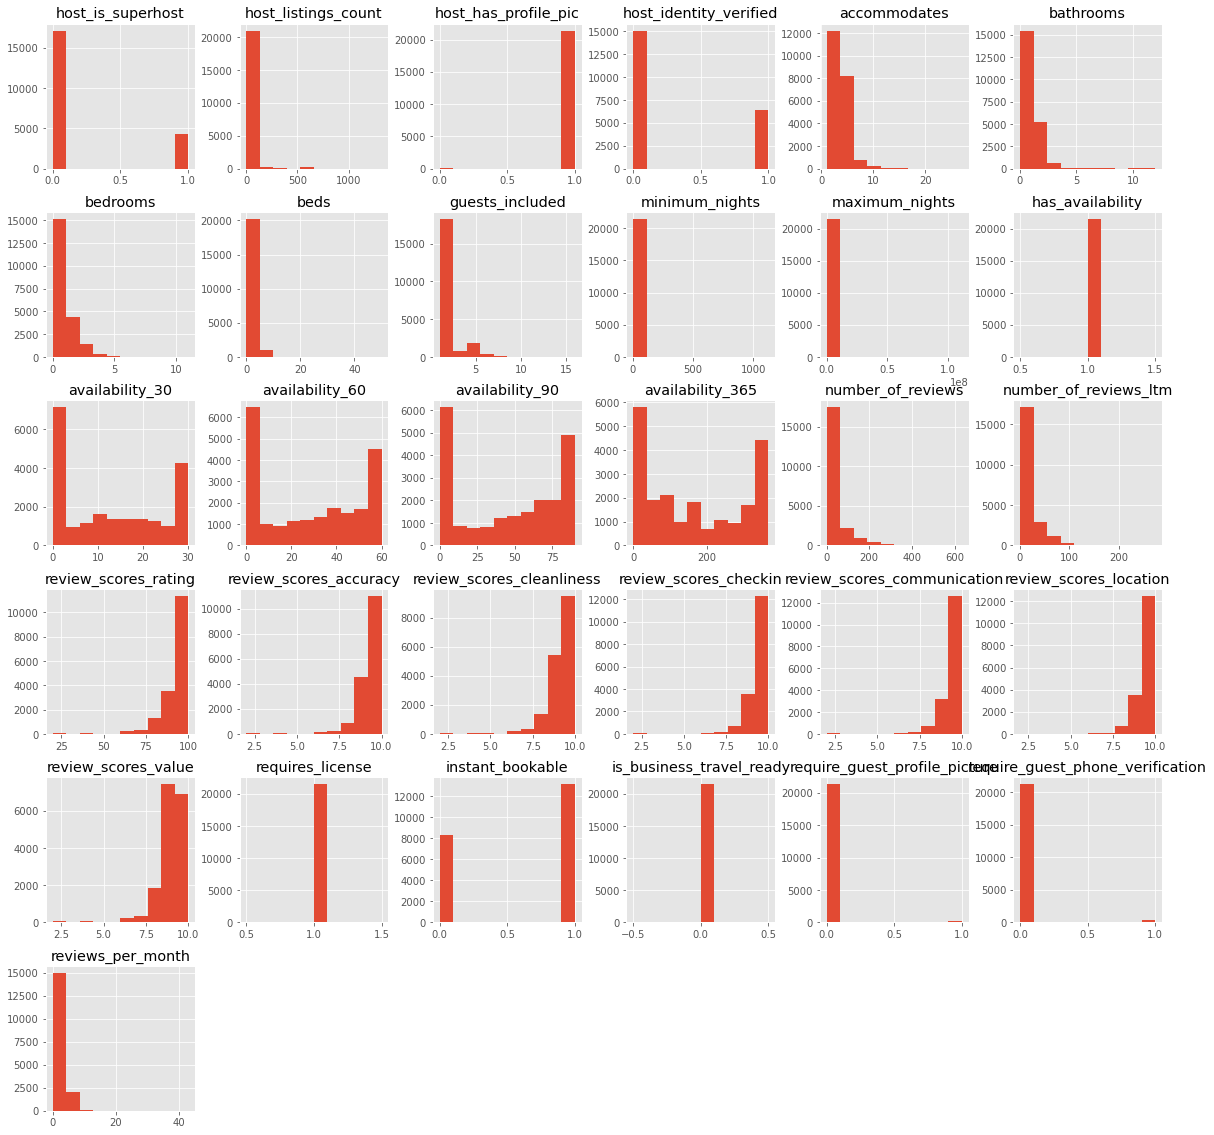

In [18]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

From the above, it can be seen that several columns only contain one category and can be dropped:

In [19]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 
         'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

#### Variables description:

- `experiences_offered` - slightly unclear as it does not appear to directly relate to Airbnb Experiences, but this seems to be the main recommended category of travel type, e.g. business

- `host_since` - date that the host first joined Airbnb

- `host_response_time` - average amount of time the host takes to reply to messages

- `host_response_rate` - proportion of messages that the host replies to

- `host_is_superhost` - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb

- `host_listings_count` - how many listings the host has in total

- `host_identity_verified` - whether or not the host has been verified with id

- `neighbourhood_cleansed` - the Madrid borough the property is in

- `property_type` - type of property, e.g. house or flat

- `room_type` - type of listing, e.g. entire home, private room or shared room

- `accommodates` - how many people the property accommodates

- `bathrooms` - number of bathrooms

- `bedrooms` - number of bedrooms

- `beds` - number of beds

- `bed_type` - type of bed, e.g. real bed or sofa-bed

- `amenities` - list of amenities

- `price` - nightly advertised price (the target variable)

- `security_deposit` - the amount required as a security deposit

- `cleaning_fee` - the amount of the cleaning fee (a fixed amount paid per booking)

- `guests_included` - the number of guests included in the booking fee

- `extra_people` - the price per additional guest above the guests_included price

- `minimum_nights` - the minimum length of stay

- `maximum_nights` - the maximum length of stay

- `calendar_updated` - when the host last updated the calendar

- `availability_30` - how many nights are available to be booked in the next 30 days

- `availability_60` - how many nights are available to be booked in the next 60 days

- `availability_90` - how many nights are available to be booked in the next 90 days

- `availability_365` - how many nights are available to be booked in the next 365 days

- `number_of_reviews` - the number of reviews left for the property

- `number_of_reviews_ltm` - the number of reviews left for the property in the last twelve months

- `first_review` - the date of the first review

- `last_review` - the date of the most recent review

- `review_scores_rating` - guests can score properties overall from 1 to 5 stars

- `review_scores_accuracy` - guests can score the accuracy of a property's description from 1 to 5 stars

- `review_scores_cleanliness` - guests can score a property's cleanliness from 1 to 5 stars

- `review_scores_checkin` - guests can score their check-in from 1 to 5 stars

- `review_scores_communication` - guests can score a host's communication from 1 to 5 stars

- `review_scores_location` - guests can score a property's location from 1 to 5 stars

- `review_scores_value` - guests can score a booking's value for money from 1 to 5 stars

- `instant_bookable` - whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)

- `cancellation_policy` - the type of cancellation policy, e.g. strict or moderate

- `reviews_per_month` - calculated field of the average number of reviews left by guest each month

#### Cleaning individual columns

##### `Experiences_offered`

Most listings offer no experiences so this feature can be dropped.

In [20]:
df.experiences_offered.value_counts()

none    21495
Name: experiences_offered, dtype: int64

In [21]:
df.drop('experiences_offered', axis=1, inplace=True)

##### `host_since`

This is a datetime column, and will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was scraped (July 21, 2019). The original column will be left in initially for EDA, and dropped later.

In [22]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (pd.datetime(2019, 7, 21) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1142.0
Median days as host: 1099.0


##### `host_response_time`

About a third of rows don't have a value for `host_response_time`, and the majority of these have also not yet been reviewed. Therefore this section of the data set consists primarily of properties which have not yet had a completed stay (most likely properties which have not yet had a booking, although may also include properties that have a booking currently occuring). Although this is a considerable proportion of the dataset, these listings will be retained in the data because they are still legitimate properties with advertised prices, and are still part of the comparative market when considering the price for which to advertise your Airbnb listing. However, if the dataset being used had the actual average price paid as its target, it would be necessary to drop these rows because they would not have a value, as they have not yet been booked.

It is worth noting, however, that this group of listings probably also contains a large number of 'inactive' listings. These are properties which have been speculatively listed on Airbnb but either have their calendars closed (so no stays can be booked), or have prices which are notably higher than other properties in their area.
Because `host_response_time` is unknown for so many listings, it will be retained as its own category, `'unknown'`.

In [23]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
#len(df[df.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 4617
Proportion: 21.5%


In [24]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

within an hour        0.582508
unknown               0.214794
within a few hours    0.115422
within a day          0.068062
a few days or more    0.019214
Name: host_response_time, dtype: float64

In [25]:
df.host_response_time.value_counts(normalize=True)

within an hour        0.582508
unknown               0.214794
within a few hours    0.115422
within a day          0.068062
a few days or more    0.019214
Name: host_response_time, dtype: float64

##### `host_response_rate`

A similar story is true for *host_response_rate*, with about a third of values being null. This will also be kept as its own category, after grouping other values into meaningful groups (i.e. transforming this into a categorical feature, rather than a numerical one). Because about 75% of hosts respond 100% of the time, this will be kept as its own category, and other values will be grouped into bins.

In [26]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 4617
Proportion: 21.5%


In [27]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 94.0
Median host response rate: 100.0
Proportion of 100% host response rates: 69.7%


In [28]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, 
                               bins=[0, 50, 90, 99, 100], 
                               labels=['0-49%', '50-89%', '90-99%', '100%'], 
                               include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       11765
unknown     4617
50-89%      2488
90-99%      2038
0-49%        587
Name: host_response_rate, dtype: int64

##### `host_is_superhost`

There are 21 rows lacking values for each of five different host-related features. These rows will be dropped.

In [29]:
# Number of rows without a value for multiple host-related columns
len(df[df.loc[ :,['host_is_superhost', 'host_listings_count', 'host_identity_verified'] ].isnull().sum(axis=1) == 5])

0

In [30]:
df.dropna(subset=['host_since'], inplace=True)

##### `property_type`

Some cleaning of property types is required as there are a large number of categories with only a few listings. The categories `Apartment`, `House` and `Other` will be used, as most properties can be classified as either apartment or house.

In [31]:
df.property_type.value_counts()

Apartment                 17520
House                      1187
Condominium                 818
Loft                        741
Serviced apartment          294
Hostel                      239
Bed and breakfast           121
Guest suite                  79
Boutique hotel               73
Other                        68
Townhouse                    67
Guesthouse                   67
Chalet                       47
Hotel                        47
Tiny house                   22
Casa particular (Cuba)       21
Camper/RV                    19
Villa                        10
Dome house                    6
Aparthotel                    6
Barn                          3
Hut                           3
Earth house                   3
Bungalow                      2
Farm stay                     1
Tent                          1
Pension (South Korea)         1
Cave                          1
Nature lodge                  1
Igloo                         1
Yurt                          1
Name: pr

In [32]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

##### `bathrooms`, `bedrooms` and `beds`

Missing values will be replaced with the median (to avoid strange fractions).

In [33]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

##### `bed_type`

Most listings have the same bed type, so it won't constitute a comparative advantage to have this feature. So this feature can be dropped.

In [34]:
df.bed_type.value_counts()

Real Bed         21304
Pull-out Sofa      142
Futon               15
Couch                6
Airbed               3
Name: bed_type, dtype: int64

In [35]:
df.drop('bed_type', axis=1, inplace=True)

##### `amenities`

Amenities is a list of additional features in the property, i.e. whether it has a TV or parking. Examples are below:

In [36]:
# Example of amenities listed
df.amenities[:1].values

array(['{Wifi,"Air conditioning",Kitchen,Elevator,Heating,"Family/kid friendly",Washer,Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Hot water","Bed linens","Extra pillows and blankets","Pocket wifi"}'],
      dtype=object)

In [37]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Amazon Echo',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Baking sheet',
 'Balcony',
 'Barbecue utensils',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Bread maker',
 'Breakfast',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Central air conditioning',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Double oven',
 'Dryer',
 'EV charger',
 'Elevator',
 'En suite bathroom',
 'Espre

In the list above, some amenities are more important than others (i.e. a balcony is more likely to increase price than a fax machine), and some are likely to be fairly uncommon (i.e.. 'Electric profiling bed'). For the purpose of this project, amenities will be extracted based on quick research into which amenities are considered by guests a selection of the more important as well as personal experience. These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

The amenities chosen are (slashes indicate separate categories that can be combined):

- 24-hour check-in
- Air conditioning/central air conditioning
- Amazon Echo/Apple TV/DVD player/game console/Netflix/projector and screen/smart TV (i.e. non-basic electronics)
- BBQ grill/fire pit/propane barbeque
- Balcony/patio or balcony
- Beach view/beachfront/lake access/mountain view/ski-in ski-out/waterfront (i.e. great location/views)
- Bed linens
- Breakfast
- Cable TV/TV
- Coffee maker/espresso machine
- Cooking basics
- Dishwasher/Dryer/Washer/Washer and dryer
- Elevator
- Exercise equipment/gym/private gym/shared gym
- Family/kid friendly, or anything containing 'children'
- Free parking on premises/free street parking/outdoor parking/paid parking off premises/paid parking on premises
- Garden or backyard/outdoor seating/sun loungers/terrace
- Host greets you
- Hot tub/jetted tub/private hot tub/sauna/shared hot tub/pool/private pool/shared pool
- Internet/pocket wifi/wifi
- Long term stays allowed
- Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s)
- Private entrance
- Safe/security system
- Self check-in
- Smoking allowed
- Step-free access/wheelchair accessible, or anything containing 'accessible'
- Suitable for events

In [38]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

One way to reduce the number of features is to remove the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings. Amenity features where either the true or the false category contains fewer than 10% of listings will be removed.

In [39]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,41:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'high_end_electronics', 'bbq', 'nature_and_views', 'gym', 'outdoor_space', 'hot_tub_sauna_or_pool', 'secure', 'self_check_in', 'accessible', 'event_suitable']


In [40]:
df.columns[40:]

Index(['air_conditioning', 'balcony', 'bed_linen', 'breakfast', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'elevator',
       'child_friendly', 'parking', 'host_greeting', 'internet',
       'long_term_stays', 'pets_allowed', 'private_entrance',
       'smoking_allowed'],
      dtype='object')

##### `price`

Price will be converted to an integer. Currently it is a string because there is a currency sign.

In [41]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

##### `security_deposit`

As with price, this will be converted to an integer.

Having a missing value for security deposit is functionally the same as having a security deposit of €0, so missing values will be replaced with 0.

In [42]:
df.security_deposit.isna().sum()

7039

In [43]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

##### `cleaning_fee`

As with price, this will be converted to an integer.

As with security deposit, having a missing value for cleaning fee is functionally the same as having a cleaning fee of €0, so missing values will be replaced with 0.

In [44]:
df.cleaning_fee.isna().sum()

5209

In [45]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

##### `extra_people`

As with price, this will be converted to an integer.

As with security deposit, having a missing value for extra people is functionally the same as having an extra people fee of €0, so missing values will be replaced with 0.

In [46]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

##### `calendar_updated` 

There are 96 unique categories for *calendar_updated*, and it is not entirely clear what this feature is adding to the model (a host might update their calendar for multiple different reasons). Therefore this column will be dropped.

In [47]:
df.drop('calendar_updated', axis=1, inplace=True)

##### `availability`

There are multiple different measures of availability, which will be highly correlated with each other. Only one will be retained, availability for 90 days (`availability_90`). This is due to the seemingly inevitable enforcement of London-like regulations proposed by the Scottish Government (90 days per year rents) after significant and growing concern from local residents and housing organisations over the increase of Airbnb and other short term lets within Madrid city, where there is now one Airbnb listing for every 11 residents.

In [48]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

##### `first_review` and `last_review`

Almost 20 percent of listings have not had a review written for them. This is too large a proportion of the dataset to drop, and dropping the columns would lose a lot of useful information because reviews are very important in people's decisions to book, and therefore price.

This is also too large a proportion of the dataset to simply replace with median/mean values, as this would skew the distribution substantially. Also, the missing values here are not really missing values, as the fact that they are `NaN`s is meaningful - it tells us that these are new or previously unbooked listings that have not had reviews yet. In order to make the resulting model work able to predict prices for any Airbnb listing, including brand new listings, is is actually beneficial to keep them in. Therefore, these will be kept as an `unknown` category, and the feature will have to be treated as categorical (and therefore one-hot encoded) rather than numerical.

In [49]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 19.9%
Null values in 'review_scores_rating': 21.2%


In [50]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (pd.datetime(2019, 4, 9) - df.first_review).astype('timedelta64[D]')

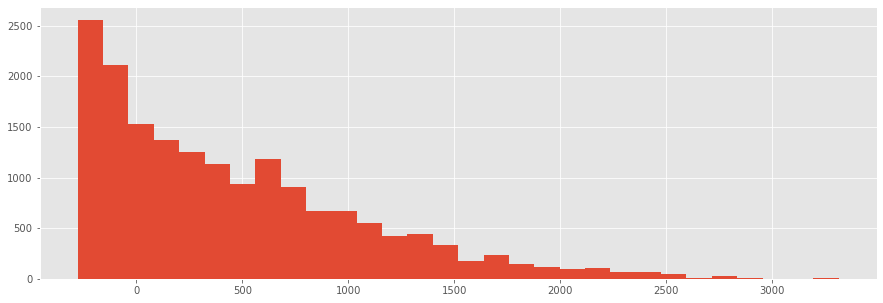

In [51]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [52]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [53]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

Same process for `last_review`

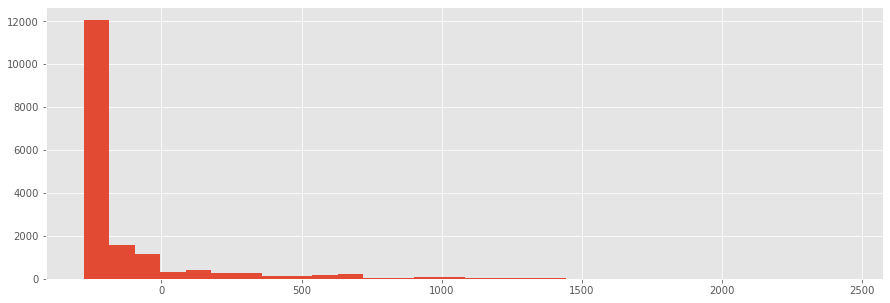

In [54]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (pd.datetime(2019, 4, 9) - df.last_review).astype('timedelta64[D]')

# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [55]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [56]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

##### `review` ratings columns

As above, listings without reviews will be kept and replaced with `unknown`. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together (as this is, by Airbnb standards, a 'low' rating).

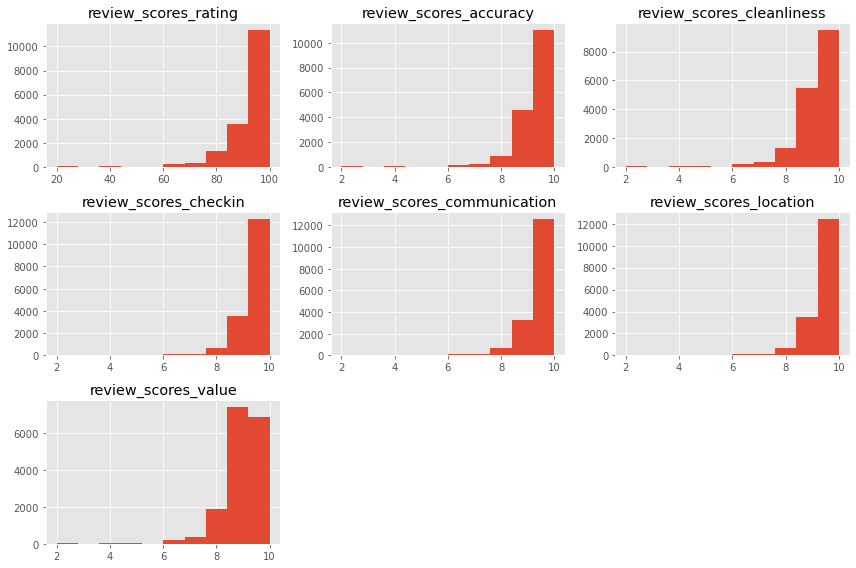

In [57]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [58]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [59]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [60]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

##### `cancellation_policy`

Some cleaning of cancellation policy types is required, in order to categorise the four very small categories into the three larger categories (e.g. the super strict options are only available to long-term Airbnb hosts, and is invitation only).

In [61]:
df.cancellation_policy.value_counts()

strict_14_with_grace_period    7543
flexible                       6988
moderate                       6730
super_strict_30                 138
super_strict_60                  71
Name: cancellation_policy, dtype: int64

In [62]:
# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

##### `number_of_reviews_ltm` and `reviews_per_month`

These will be highly correlated with `number_of_reviews` and so will be dropped.

In [63]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

In [64]:
df.head()
df.dtypes

host_since                     datetime64[ns]
host_response_time                     object
host_response_rate                     object
host_is_superhost                     float64
host_listings_count                   float64
host_identity_verified                float64
neighbourhood_cleansed                 object
property_type                          object
room_type                              object
accommodates                            int64
bathrooms                             float64
bedrooms                              float64
beds                                  float64
price                                   int64
security_deposit                        int64
cleaning_fee                            int64
guests_included                         int64
extra_people                            int64
minimum_nights                          int64
maximum_nights                          int64
availability_90                         int64
number_of_reviews                 

In [65]:
# Save cleaned dataset
listings_cleaned = df.to_csv(r'output/listings_cleaned.csv', index=id, header=True)

### 4. Exploratory Data Analysis

#### Time Series

Time is an important factor to consider in a model when we wish to predict prices or trends. Enter **time series**. A time series is simply a series of data points ordered in time. In a time series, time is often the independent variable and the goal is usually to make a forecast for the future. There are also other questions that come to play when dealing with time series. For example: Is there any *seasonality* to the price? Is it *stationary*? Even though we may not be able to include this aspect into our model, it is good to explore it to be aware of it and be able to make recommendations for future research. Thus, in this section, we will explore this aspect of the data.

In [66]:
# Read dataset
df = pd.read_csv('output/listings_cleaned.csv', index_col=0)

In [67]:
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])

In [68]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")


Of the Airbnb hosts that are still listing on the site, the first joined on 14 December 2008, and the most recent joined on 10 January 2020.


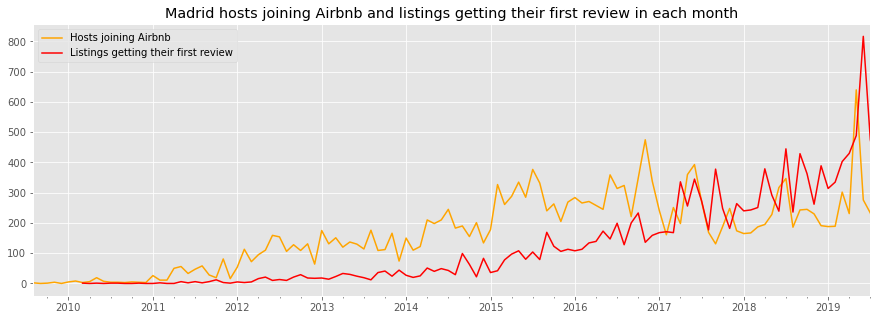

In [69]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='red')
plt.title('Madrid hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2009-08-21', '2019-07-20') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [70]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [71]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

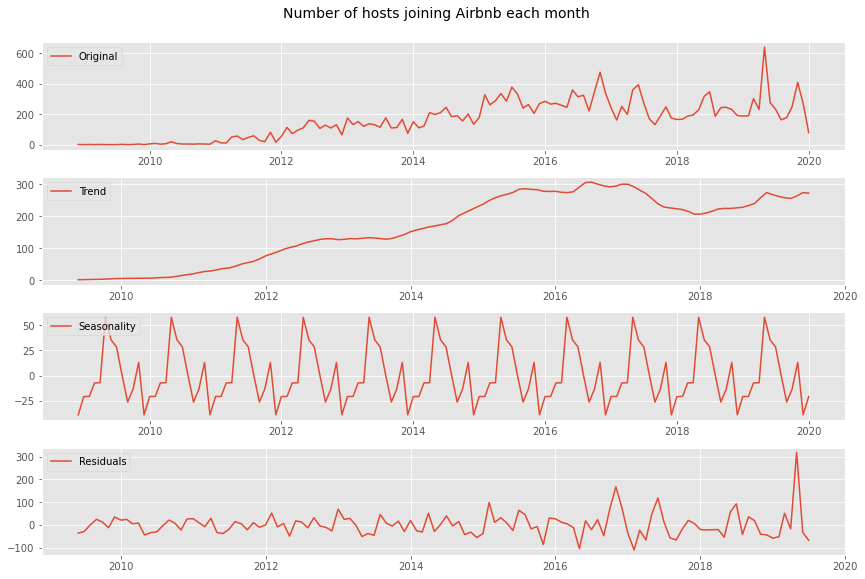

In [72]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

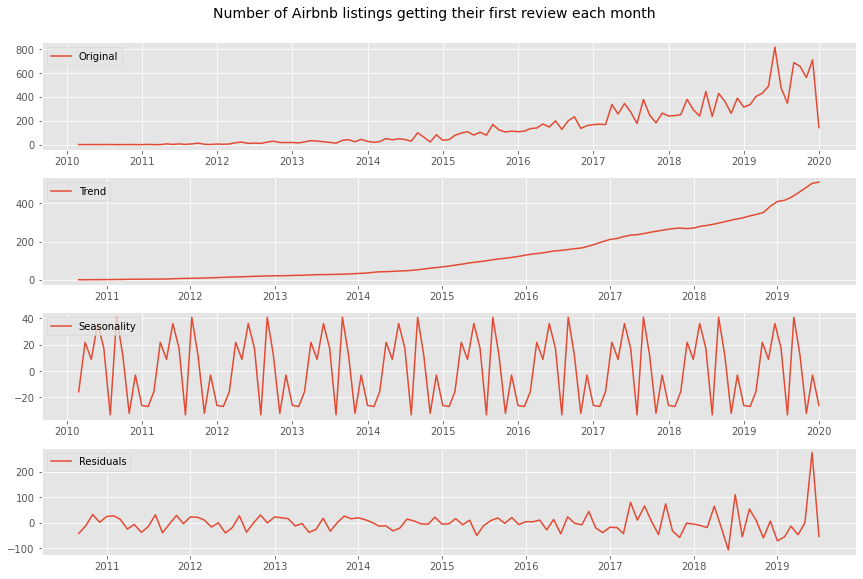

In [73]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

As seen above, there is a clear seasonality. Every year, you see a peak towards hosts joining after summer and before it, and the lowest points are around the middle of the end of each year(summer/ August primarily). There is a big peak in the number of hosts joining Airbnb between 2019 and 2020. Indeed, there has been a fast growth of Airbnb since middle 2015. This was the year when Airbnb became increasingly popular for short-term lease, as a way to get around local legislation and taxation. Also we can observe how much COVID affected everything, incluiding Airbnb.

Another important pattern to observe is the number of listings per owner/host. There are a number of professional Airbnb management companies which host a large number of listings under a single host profile. However, there is no consistent upwards trend in the average number of properties managed by each host.

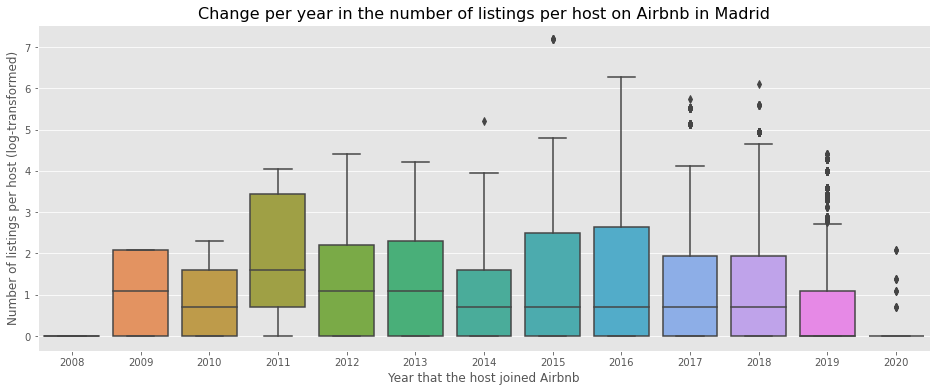

In [74]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in Madrid', fontsize=16)
plt.show()

In [75]:
print("Average number of listings per host per year on Airbnb in Madrid:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in Madrid:
host_since
2008-01-01     1.00
2009-01-01     4.56
2010-01-01     3.28
2011-01-01    14.92
2012-01-01     6.21
2013-01-01     9.24
2014-01-01     5.94
2015-01-01    16.08
2016-01-01    47.20
2017-01-01    11.44
2018-01-01    12.73
2019-01-01     5.17
2020-01-01     0.97
Freq: AS-JAN, Name: host_listings_count, dtype: float64


In [76]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
id,,
17250237,2015-02-20,121.0
28823679,2018-07-31,140.0
32402935,2017-05-05,170.0
26798375,2014-03-15,181.0
33739306,2017-07-28,249.0
34921416,2018-07-12,268.0
37307766,2017-11-08,309.0
31157282,2018-09-03,450.0
18762532,2016-11-08,531.0


In term of changes in prices over time, the average price per night for Airbnb listings in Madrid has maintained the last 10 years. In particular, the top end of property prices has increased.

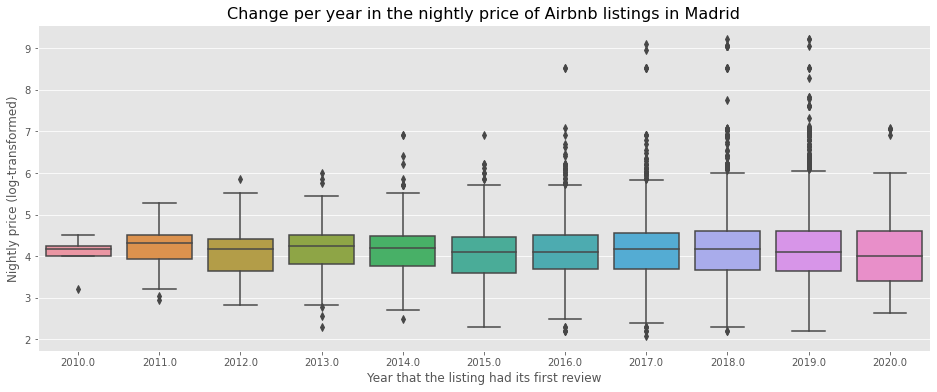

In [77]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Madrid', fontsize=16)
plt.show()

In [78]:
print("Mean nightly price of listings in each year on Airbnb in Madrid:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in Madrid:
first_review
2010-01-01     61.00
2011-01-01     74.42
2012-01-01     69.38
2013-01-01     75.91
2014-01-01     78.52
2015-01-01     70.97
2016-01-01     82.35
2017-01-01     91.60
2018-01-01    117.68
2019-01-01    111.79
2020-01-01    108.56
Name: price, dtype: float64


In [79]:
print("Median nightly price of listings in each year on Airbnb in Madrid:")
print(round(df.set_index('first_review').price.resample('YS').median(),2))

Median nightly price of listings in each year on Airbnb in Madrid:
first_review
2010-01-01    65.0
2011-01-01    74.5
2012-01-01    65.0
2013-01-01    70.0
2014-01-01    66.0
2015-01-01    60.0
2016-01-01    61.0
2017-01-01    65.0
2018-01-01    65.0
2019-01-01    60.0
2020-01-01    55.0
Name: price, dtype: float64


In [80]:
# Dropping host_since and first_review as they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

#### Numerical Features

In [81]:
df.describe()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,instant_bookable,host_days_active,air_conditioning,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,smoking_allowed
count,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,2.147000e+04,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.00000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000,21470.000000
mean,0.201258,16.507685,0.297345,3.295668,1.298440,1.352259,1.986912,130.421891,103.686446,23.838519,1.766605,8.528598,4.416628,6.441628e+03,45.238333,37.834141,0.611598,1142.453004,0.629530,0.140615,0.411504,0.121612,0.78980,0.437680,0.431765,0.836190,0.554355,0.310387,0.441360,0.317000,0.955240,0.285422,0.142944,0.135678,0.207126
std,0.400949,65.161782,0.457100,2.024043,0.726343,0.858113,1.534295,361.000358,226.517408,34.041934,1.404057,16.315488,21.767328,7.620751e+05,34.680596,65.648440,0.487398,815.267934,0.482942,0.347632,0.492118,0.326844,0.40746,0.496113,0.495334,0.370112,0.497048,0.462663,0.496561,0.465318,0.206782,0.451625,0.350024,0.342454,0.405256
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,40.000000,0.000000,0.000000,1.000000,0.000000,1.000000,4.000000e+01,1.000000,1.000000,0.000000,443.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,0.000000,3.000000,1.000000,1.000000,2.000000,65.000000,0.000000,19.000000,1.000000,0.000000,2.000000,1.125000e+03,51.000000,9.000000,1.000000,1099.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,7.000000,1.000000,4.000000,1.500000,2.000000,2.000000,101.000000,150.000000,35.000000,2.000000,15.000000,3.000000,1.125000e+03,78.000000,45.000000,1.000000,1696.000000,1.000000,0.000000,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1321.000000,1.000000,27.000000,12.000000,11.000000,50.000000,9999.000000,4460.000000,550.000000,16.000000,271.000000,1125.000000,1.111111e+08,90.000000,634.000000,1.000000,3871.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


`price`

In [82]:
print(f"Advertised prices range from €{min(df.price)} to €{max(df.price)}.")

Advertised prices range from €1 to €9999.


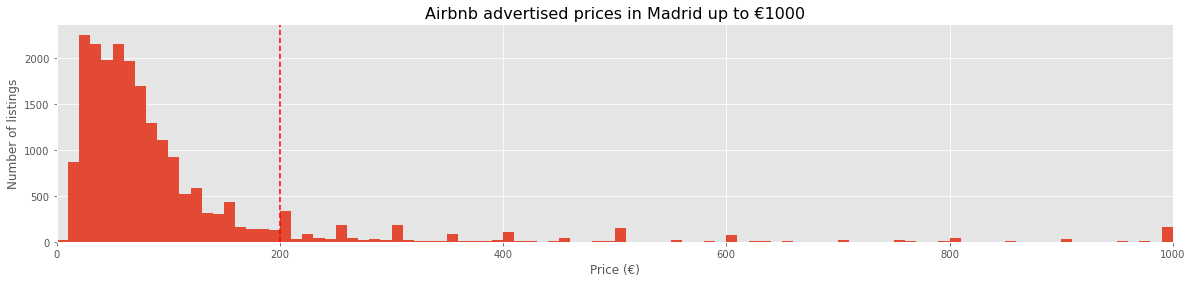

In [83]:
# Distribution of prices from €0 to €1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='red', linestyle='--')
plt.title("Airbnb advertised prices in Madrid up to €1000", fontsize=16)
plt.xlabel("Price (€)")
plt.ylabel("Number of listings")
plt.show()

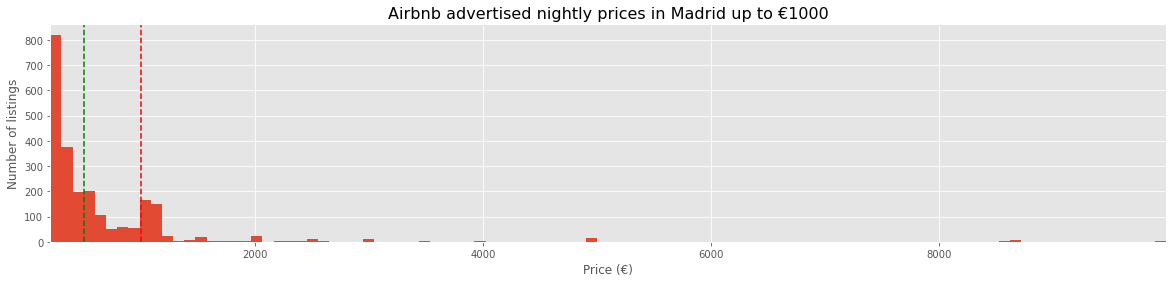

In [84]:
# Distribution of prices from €200 upwards
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(200, max(df.price)))
plt.margins(x=0)
plt.axvline(500, color='green', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Madrid up to €1000", fontsize=16)
plt.xlabel("Price (€)")
plt.ylabel("Number of listings")
plt.show()

In [85]:
# Replacing values under €10 with €10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over €1000 with €1000
df.loc[df.price >= 1000, 'price'] = 1000

`host_listings_count`

Two difficulties in discerning how many listings hosts have on average are: 

1) this number is only known on the level of the listing, so hosts with more listings are represented more frequently (e.g a host with 10 listings may be represented up to 10 times in the dataset)

2) a host's other listings may not be in Madrid, so some multi-listing hosts may appear multiple times in the dataset, and others may appear only once

In [86]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print("Highest number of listins per host:", int(round(df.host_listings_count.max())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 2
Mean number of listings per host: 17
Highest number of listins per host: 1321
36% of listings are from hosts with one listing.


`accommodates`, `bathrooms`, `bedrooms` and `beds`

The most common property setup sleeps two people in one bed in one bedroom, with one bathroom. Unsurprisingly, properties that accommodate more people achieve noticeably higher rates per night, with diminishing returns coming after about 10 people.

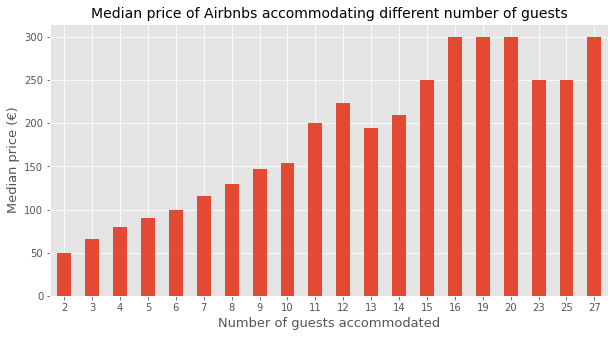

In [87]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (€)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

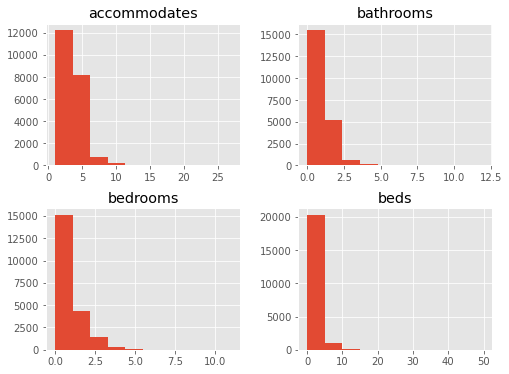

In [88]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

#### Categorical Features

`Neighbourhood`

Much of Airbnb listings are centred around Madrid's Old Town.

In [89]:
# Renaming the neighbourhood column
df.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

# Importing the Madrid borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file(r'dataset_nuevo/neighbourhoods.geojson')
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Palacio,Centro,"MULTIPOLYGON (((-3.70584 40.42030, -3.70625 40..."
1,Embajadores,Centro,"MULTIPOLYGON (((-3.70384 40.41432, -3.70277 40..."
2,Cortes,Centro,"MULTIPOLYGON (((-3.69796 40.41929, -3.69645 40..."
3,Justicia,Centro,"MULTIPOLYGON (((-3.69546 40.41898, -3.69645 40..."
4,Universidad,Centro,"MULTIPOLYGON (((-3.70107 40.42134, -3.70155 40..."


In [90]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('borough').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = df.groupby('borough').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

borough_map_df.head()

,geometry,number_of_listings,median_price
neighbourhood,,,
Palacio,"MULTIPOLYGON (((-3.70584 40.42030, -3.70625 40...",1555.0,75.0
Embajadores,"MULTIPOLYGON (((-3.70384 40.41432, -3.70277 40...",2810.0,65.0
Cortes,"MULTIPOLYGON (((-3.69796 40.41929, -3.69645 40...",1024.0,80.0
Justicia,"MULTIPOLYGON (((-3.69546 40.41898, -3.69645 40...",1207.0,80.0
Universidad,"MULTIPOLYGON (((-3.70107 40.42134, -3.70155 40...",2090.0,70.0


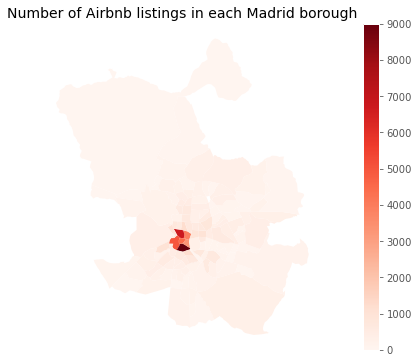

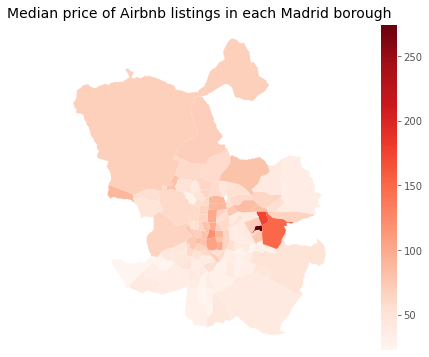

In [91]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Reds', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Madrid borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='Reds', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Madrid borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

`property_type` and `room_type` 

About 80% of properties are apartments/flats. The remainder are houses or more uncommon property types (e.g. `bed and breakfast`).

About 62% of listings are entire homes (i.e. you are renting the entire property on your own). Most of the remainder are private rooms (i.e. you are renting a bedroom and possibly also a bathroom, but there will be other people in the property). Fewer than 1% are shared rooms (i.e. you are sharing a room with either the property owner or other guests).

In [92]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

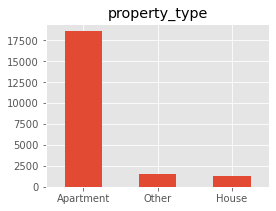

Apartment    0.864229
Other        0.073451
House        0.062320
Name: property_type, dtype: float64


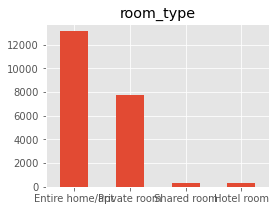

Entire home/apt    0.611411
Private room       0.359758
Shared room        0.014765
Hotel room         0.014066
Name: room_type, dtype: float64


In [93]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(df[col].value_counts(normalize=True))

`review` categories

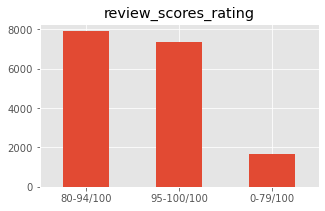

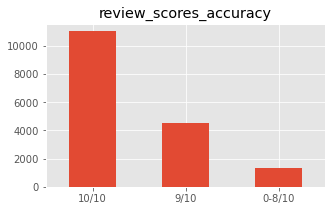

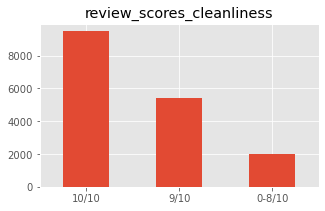

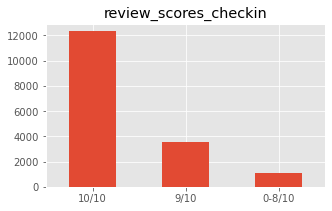

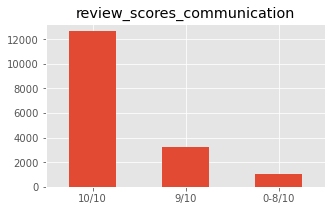

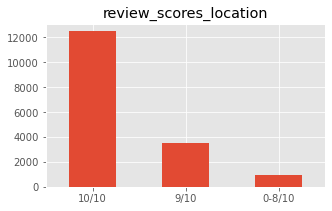

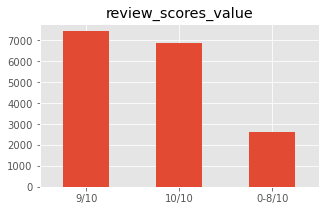

In [94]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

`first_review` and `last_review`

The most common time period in which currently live Airbnb listings had their first review is 2-3 years. This means that a lot of listings on the site have been active for at least a couple of years. Relatively few have been active for more than four years, however.

The most common category for the time since a listing received its last review is 1+ years. This means that a lot of listings have not been reviewed recently. The majority of these are probably what are sometimes referred to 'inactive' listings, because although they are technically live on the site, they do not have their calendards open and are not available to book.

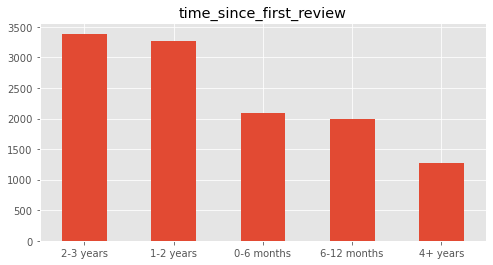

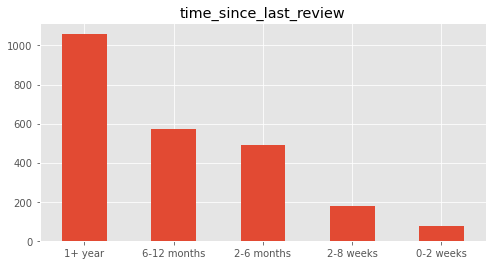

In [95]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

**Venue proximity**

As part of our model, we are looking to explore proximity to certain venues as a possible price predictor. Walkability and ability to reach places maybe a deal-maker or breaker when it comes to choosing a accomodation. Proximity to certain venues, such as principal touristic attractions, restaurants, cafes and even shops could help us predict price. For this, we will use *Foursquare API* to explore the venues per neighbourhood. As discussed before, Old Town is the area which concentrates the majority of Airbnb listings. 

We now retrieve the list of venues with their locations. We will use *Foursquare API* to explore the venues around the listings, using the latitude and longitude of each neighbourhood. We dill then find out which venues are the most common and select the most common venues as points of interest (POIS) for our accessibility analysis.

In [96]:
# Define Foursquare Credentials 
load_dotenv()
CLIENT_ID = os.getenv('CLIENT_ID') # your Foursquare ID
CLIENT_SECRET = os.environ.get('CLIENT_SECRET') # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')

Your credentails:


In [97]:
map_df.head()

,neighbourhood,geometry
0,Palacio,"MULTIPOLYGON (((-3.70584 40.42030, -3.70625 40..."
1,Embajadores,"MULTIPOLYGON (((-3.70384 40.41432, -3.70277 40..."
2,Cortes,"MULTIPOLYGON (((-3.69796 40.41929, -3.69645 40..."
3,Justicia,"MULTIPOLYGON (((-3.69546 40.41898, -3.69645 40..."
4,Universidad,"MULTIPOLYGON (((-3.70107 40.42134, -3.70155 40..."


We need the latitude and longitude of the neighbourhoods to retrieve the venues per neghbourhood. We can access this from the `geometry` column of our GeoDataFrame.

In [98]:
type(map_df.geometry)

geopandas.geoseries.GeoSeries

From `geometry` column in the GeoDataFrame, we can see that it returns a GeoSeries. To retrieve the venues per neighbourhood, we first extract the latitude and longitude or `x` and `y` from the point object in the GeoSeries. The following code returns `x` and `y` as separate GeoDataFrame columns within the original `map_df`. 

In [99]:
map_df["longitude"] = map_df.centroid.x
map_df["latitude"] = map_df.centroid.y

In [100]:
map_df.head()

,neighbourhood,geometry,longitude,latitude
0,Palacio,"MULTIPOLYGON (((-3.70584 40.42030, -3.70625 40...",-3.713981,40.415428
1,Embajadores,"MULTIPOLYGON (((-3.70384 40.41432, -3.70277 40...",-3.702372,40.409247
2,Cortes,"MULTIPOLYGON (((-3.69796 40.41929, -3.69645 40...",-3.696740,40.414853
3,Justicia,"MULTIPOLYGON (((-3.69546 40.41898, -3.69645 40...",-3.696569,40.423668
4,Universidad,"MULTIPOLYGON (((-3.70107 40.42134, -3.70155 40...",-3.706979,40.425678


In [101]:
# Function to loop for venues through all neighbourhoods
#url = 'https://api.foursquare.com/v2/venues/search?categoryId=50aa9e094b90af0d42d5de0d,530e33ccbcbc57f1066bbff3,530e33ccbcbc57f1066bbff9,4f2a25ac4b909258e854f55f&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format()
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
         # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we run the above function on each neighborhood and create a new dataframe called *madrid_venues*.

In [102]:
madrid_venues = getNearbyVenues(names=map_df['neighbourhood'],
                                   latitudes=map_df['latitude'],
                                   longitudes=map_df['longitude'],
                                 radius = 500
                                  )

Palacio
Embajadores
Cortes
Justicia
Universidad
Sol
Imperial
Acacias
Chopera
Legazpi
Delicias
Palos de Moguer
Atocha
Pacífico
Adelfas
Estrella
Ibiza
Jerónimos
Niño Jesús
Recoletos
Goya
Fuente del Berro
Guindalera
Lista
Castellana
El Viso
Prosperidad
Pavones
Ciudad Jardín
Hispanoamérica
Nueva España
Castilla
Bellas Vistas
Cuatro Caminos
Castillejos
Vallehermoso
El Pardo
Almenara
Valdeacederas
Berruguete
Gaztambide
Arapiles
Trafalgar
Almagro
Rios Rosas
Fuentelareina
Peñagrande
Argüelles
Pilar
La Paz
Valdezarza
Valverde
Casa de Campo
Mirasierra
El Goloso
Horcajo
Ciudad Universitaria
Numancia
Valdemarín
El Plantío
Aravaca
Cármenes
Puerta del Angel
Lucero
Aluche
San Isidro
Campamento
Cuatro Vientos
Aguilas
Comillas
Opañel
Vista Alegre
Puerta Bonita
Buenavista
Abrantes
Orcasitas
Orcasur
San Fermín
Almendrales
Moscardó
Zofío
Pradolongo
Portazgo
Entrevías
San Diego
Palomeras Bajas
Palomeras Sureste
Marroquina
Media Legua
Fontarrón
Vinateros
Ventas
Pueblo Nuevo
Quintana
Concepción
San Pascual
S

Checking the size of the returning dataframe

In [103]:
print(madrid_venues.shape)
madrid_venues.head()

(2030, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Palacio,40.415428,-3.713981,Santa Iglesia Catedral de Santa María la Real ...,40.415767,-3.714516,Church
1,Palacio,40.415428,-3.713981,Cervecería La Mayor,40.415218,-3.712194,Beer Bar
2,Palacio,40.415428,-3.713981,Plaza de la Almudena,40.416320,-3.713777,Plaza
3,Palacio,40.415428,-3.713981,Mercado Jamón Iberico,40.415442,-3.711643,Market
4,Palacio,40.415428,-3.713981,Charlie Champagne,40.413936,-3.712647,Restaurant


In [104]:
#!pwd
# Saving Data set
madrid_venues.to_csv(r'output/Madrid_Venues.csv')

In [105]:
# Read dataset
madrid_venues = pd.read_csv('output/madrid_venues.csv', index_col=0)

Venues returned per neighbourhood

In [106]:
madrid_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Abrantes,5,5,5,5,5,5
Acacias,30,30,30,30,30,30
Adelfas,30,30,30,30,30,30
Aguilas,9,9,9,9,9,9
Alameda de Osuna,23,23,23,23,23,23
...,...,...,...,...,...,...
Valverde,6,6,6,6,6,6
Ventas,5,5,5,5,5,5
Vinateros,12,12,12,12,12,12


**Unique categories of venues**

In [107]:
print('There are {} unique categories.'.format(len(madrid_venues['Venue Category'].unique())))

There are 246 unique categories.


**Number of venues per category**

In [108]:
madrid_venues.groupby('Venue Category').count()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,1,1,1,1,1,1
Adult Boutique,1,1,1,1,1,1
Airport,1,1,1,1,1,1
Airport Service,1,1,1,1,1,1
American Restaurant,5,5,5,5,5,5
...,...,...,...,...,...,...
Warehouse Store,1,1,1,1,1,1
Whisky Bar,1,1,1,1,1,1
Wine Bar,5,5,5,5,5,5


**Analysis per neighbourhood**

In [109]:
# One Hot Encoding
madrid_oneshot = pd.get_dummies(madrid_venues[['Venue Category']], prefix = "", prefix_sep = "")

## Add neighbourhood column back to df
madrid_oneshot['Neighbourhood'] = madrid_venues['Neighbourhood']

# Move neighbourhood column to the first column
fixed_columns = [madrid_oneshot.columns[-1]] + list(madrid_oneshot.columns[:-1])
madrid_onehot = madrid_oneshot[fixed_columns]

# display
madrid_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Burger Joint,Burrito Place,Bus Station,Cafeteria,Café,Campground,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,...,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trade School,Train Station,Travel Agency,Travel Lounge,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,Palacio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Palacio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Palacio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Palacio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Palacio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [110]:
# New df dimensions
madrid_onehot.shape

(2030, 247)

**Group rows by neighbourhood and by taking the mean and the frequency of occurrence of each category**

In [111]:
madrid_grouped = madrid_onehot.groupby('Neighbourhood').mean().reset_index()
madrid_grouped

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Burger Joint,Burrito Place,Bus Station,Cafeteria,Café,Campground,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,...,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trade School,Train Station,Travel Agency,Travel Lounge,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,Abrantes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.200000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Acacias,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.000000,0.0,0.0,0.0,0.000000,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.000000,0.033333,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.133333,0.0,0.0,0.000000,0.0,0.0,0.0,0.066667,0.033333,0.033333,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Adelfas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.000000,0.0,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.033333,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.066667,0.000000,0.033333,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aguilas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111,0.0,0.0,0.0,0.000000,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.111111,0.0,0.0,0.0,0.000000,0.000000,0.111111,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alameda de Osuna,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.086957,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.043478,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.086957,0.0,

**Get each neighbourhood along with its top 5 most common venues**

In [112]:
num_top_venues = 5

for hood in madrid_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = madrid_grouped[madrid_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abrantes----
                  venue  freq
0  Fast Food Restaurant   0.2
1                  Park   0.2
2    Athletics & Sports   0.2
3           Pizza Place   0.2
4         Metro Station   0.2


----Acacias----
                venue  freq
0  Spanish Restaurant  0.13
1                 Bar  0.10
2         Supermarket  0.07
3         Pizza Place  0.07
4       Indie Theater  0.07


----Adelfas----
                  venue  freq
0  Fast Food Restaurant  0.07
1           Supermarket  0.07
2                   Gym  0.07
3         Grocery Store  0.07
4                 Diner  0.03


----Aguilas----
                venue  freq
0         Sports Club  0.11
1         Pizza Place  0.11
2  Athletics & Sports  0.11
3       Train Station  0.11
4    Tapas Restaurant  0.11


----Alameda de Osuna----
               venue  freq
0         Smoke Shop  0.09
1               Park  0.09
2             Bakery  0.09
3  Food & Drink Shop  0.04
4      Metro Station  0.04


----Almagro----
                      venu

4                       Gym  0.03


----El Goloso----
               venue  freq
0            Stables  0.50
1         Restaurant  0.25
2            Dog Run  0.25
3  Accessories Store  0.00
4        Pastry Shop  0.00


----El Plantío----
                 venue  freq
0         Burger Joint  0.22
1   Italian Restaurant  0.22
2     Asian Restaurant  0.11
3  American Restaurant  0.11
4  Japanese Restaurant  0.11


----El Viso----
                      venue  freq
0        Spanish Restaurant  0.12
1  Mediterranean Restaurant  0.08
2                Restaurant  0.08
3                     Plaza  0.04
4             Metro Station  0.04


----Embajadores----
              venue  freq
0       Coffee Shop  0.13
1  Tapas Restaurant  0.10
2           Theater  0.10
3       Pizza Place  0.10
4        Restaurant  0.07


----Entrevías----
                  venue  freq
0           Music Venue  0.33
1    Turkish Restaurant  0.17
2                  Park  0.17
3  Gym / Fitness Center  0.17
4                  

                venue  freq
0  Spanish Restaurant   0.4
1         Beer Garden   0.2
2  Athletics & Sports   0.2
3                Park   0.2
4   Accessories Store   0.0




**Put that in pandas data frame**

In [113]:
# Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [114]:
import numpy as np

# New dataframe ordered
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = madrid_grouped['Neighbourhood']

for ind in np.arange(madrid_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], 
                                                                          num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abrantes,Fast Food Restaurant,Park,Athletics & Sports,Pizza Place,Metro Station
1,Acacias,Spanish Restaurant,Bar,Supermarket,Pizza Place,Indie Theater
2,Adelfas,Fast Food Restaurant,Supermarket,Gym,Grocery Store,Diner
3,Aguilas,Sports Club,Pizza Place,Athletics & Sports,Train Station,Tapas Restaurant
4,Alameda de Osuna,Smoke Shop,Park,Bakery,Food & Drink Shop,Metro Station


**Let's look at how many categories are on the 1st most common venue.**

In [115]:
print('There are {} unique categories.'.format(len(neighbourhoods_venues_sorted['1st Most Common Venue'].unique())))

There are 40 unique categories.


In [116]:
neighbourhoods_venues_sorted.groupby('1st Most Common Venue').count()

,Neighbourhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1st Most Common Venue,,,,,
Airport,1,1,1,1,1
BBQ Joint,1,1,1,1,1
Bakery,4,4,4,4,4
Bar,3,3,3,3,3
Brewery,3,3,3,3,3
Burger Joint,2,2,2,2,2
Café,1,1,1,1,1
Coffee Shop,4,4,4,4,4
Fast Food Restaurant,6,6,6,6,6


From above, we observe that the most common venues across the dataset are Spanish Restaurant, Restaurant. It is clear that different restaurant venues are in subcategories which makes them less common than if they were aggregated. Thus, for the purpose accounting for the venues that may have the most impact on price, we will limit the venues to the most common categories.Thus, that category of venues will not be considered.

### 4. Walkability to nearest venues

We will use this information on venues to select Points of Interest for which we will graph and measure access to each one. For this purpose, we will use [OSMnx](https://geoffboeing.com/2016/11/osmnx-python-street-networks/) and [Pandana](https://udst.github.io/pandana/introduction.html#contributing-to-pandana) libraries.

Pandana is a handy graph library that allows for Pandas data frames to be passed through into a network graph that maps graph-level analyses to underlying C operations. All of this is to say, it's much faster than traditional Python-based graphs, such as NetworkX.

In certain situations, such as the performance of accessibility analyses, this makes in-memory performance and iterative development based on this library possible, as opposed to what would be a cumbersome development process with tools that fail to leverage the same degree of C-level operations utilization.

#### Points of interest (POIs) and network data from OSM
We now get the points of interest. For our case, we already have the POIS retrieved using the Foursquare API. As we found out in the previous section, Pubs, Restaurants, Cafes and Supermarkets/Grocery Stores are our POIS.

In [117]:
# same withMadridvenues
madrid_venues['Venue Category'].value_counts()
#madrid_venues.head()

Spanish Restaurant           201
Restaurant                   128
Tapas Restaurant              82
Bar                           76
Park                          63
                            ... 
Pool Hall                      1
Latin American Restaurant      1
Casino                         1
Dive Shop                      1
Theme Park                     1
Name: Venue Category, Length: 246, dtype: int64

In [118]:
#Get just Pub, Cafe, Bar And Restaurant
start_time = time.time()

# Points of interest already exists. Load from madrid_venues
df_pois = madrid_venues.copy()
terms = ['Grocery Store', 'Bar', 'Pub', 'Restaurant', 'Café']
df_pois = df_pois[df_pois['Venue Category'].str.contains('|'.join(terms))]
df_pois.to_csv(r'output/foursquare_amenities.csv', index=id, header=True)
method = 'loaded from CSV'

print('{:,} POIs {} in {:,.2f} seconds'.format(len(df_pois), method, time.time()-start_time))
df_pois.head()

927 POIs loaded from CSV in 0.01 seconds


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Palacio,40.415428,-3.713981,Cervecería La Mayor,40.415218,-3.712194,Beer Bar
4,Palacio,40.415428,-3.713981,Charlie Champagne,40.413936,-3.712647,Restaurant
6,Palacio,40.415428,-3.713981,Taberna Rayuela,40.413179,-3.713496,Tapas Restaurant
11,Palacio,40.415428,-3.713981,la gastroteca de santiago,40.416639,-3.710944,Restaurant
13,Palacio,40.415428,-3.713981,Taquería del Alamillo,40.413697,-3.712549,Mexican Restaurant


In [119]:
# Making sure each variable's type makes sense
df_pois.dtypes

Neighbourhood               object
Neighbourhood Latitude     float64
Neighbourhood Longitude    float64
Venue                       object
Venue Latitude             float64
Venue Longitude            float64
Venue Category              object
dtype: object

In [120]:
# how many points of interest of each type of amenity did we retrieve?
df_pois['Venue Category'].value_counts()

Spanish Restaurant                 201
Restaurant                         128
Tapas Restaurant                    82
Bar                                 76
Café                                54
Grocery Store                       54
Italian Restaurant                  36
Mediterranean Restaurant            27
Fast Food Restaurant                26
Chinese Restaurant                  25
Seafood Restaurant                  23
Japanese Restaurant                 19
Asian Restaurant                    18
Pub                                 13
Cocktail Bar                        11
Mexican Restaurant                  10
Argentinian Restaurant               9
Sushi Restaurant                     9
Indian Restaurant                    8
Thai Restaurant                      7
Paella Restaurant                    6
Beer Bar                             6
American Restaurant                  5
Peruvian Restaurant                  5
Wine Bar                             5
Vegetarian / Vegan Restau

Restaurants are divided in sub-categories. Let's just put them together.

In [121]:
# Put all restaurant, bar and pub venues together under same name
df_pois.loc[df_pois['Venue Category'].str.contains('Restaurant', case=False), 'Venue Category'] = 'Restaurant'
df_pois.loc[df_pois['Venue Category'].str.contains('Bar', case=False), 'Venue Category'] = 'Bar'
df_pois.loc[df_pois['Venue Category'].str.contains('Pub', case=False), 'Venue Category'] = 'Pub'
df_pois['Venue Category'].value_counts()

Restaurant       689
Bar              113
Café              54
Grocery Store     54
Pub               17
Name: Venue Category, dtype: int64

Next we get the street network data from the OSM API.

In [122]:
# configure filenames to save/load network datasets

# Madrid's bounding box found here: https://boundingbox.klokantech.com/
bbox = [40.26990, -3.85876, 40.54544, -3.59440] 
bbox_string = '_'.join([str(x) for x in bbox])
net_filename = 'data/network_{}.h5'.format(bbox_string)

In [123]:
start_time = time.time()

# query the OSM API for the street network within the specified bounding box
network = osm.pdna_network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
method = 'downloaded from OSM'

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](40.26990000,-3.85876000,40.54544000,-3.59440000);>;);out;'}"
Downloaded 79,036.3KB from www.overpass-api.de in 4.83 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 7.11 seconds
Returning OSM data with 532,841 nodes and 115,672 ways...
Edge node pairs completed. Took 133.66 seconds
Returning processed graph with 166,378 nodes and 250,094 edges...
Completed OSM data download and Pandana node and edge table creation in 150.29 seconds


In [124]:
print(type(network))

<class 'pandana.network.Network'>


In [125]:
# identify nodes that are connected to fewer than some threshold of other nodes within a given distance
lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')

# remove low-connectivity nodes and save to h5
network.save_hdf5('output/mynetwork.h5',rm_nodes=lcn)

In [126]:
print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

Network with 166,378 nodes downloaded from OSM in 162.15 secs


When saving a Network to HDF5 it’s possible to exclude certain nodes. This can be useful when refining a network so that it includes only validated nodes. As an example, you can use the `low_connectivity_nodes()` method to identify nodes that may not be connected to the larger network, then exclude those nodes when saving to HDF5. In the current design of Pandana it’s not possible to modify a Network in place. Instead, save the network (with low-connectivity nodes removed) to HDF5 and then load it from that file by re-starting the notebook.

#### Calculate accessibility to any amenity we retrieved

This is where conducting geographical analysis in Python shows its power, as opposed to sitting in front of a GIS package. Pandana is built for speed. First, we'll pass it a maximum search distance. This allows a key step that speeds up future enquiries: Pandana will build a condensed representation of the network (implemented in C++), allowing rapid calculations within a defined radius of each node. We then, build a table of distances to the nearest 5 points of interest from a couple of intersections.
When this is finished, accessibility analyses for different selected amenities can be done in under a second. (Behind the scenes, two algorithms make this possible: [contraction hierarchies](https://www.mjt.me.uk/posts/contraction-hierarchies/) and [kd-trees](https://www.geeksforgeeks.org/k-dimensional-tree/).

This section of the notebook is heavily based on Professor Geoff Boeing's [Pandana demo notebook](https://nbviewer.jupyter.org/github/gboeing/urban-data-science/blob/master/20-Accessibility-Walkability/pandana-accessibility-demo-full.ipynb).

In [127]:
# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
distance = 1000
num_pois = 10
num_categories = len(df_pois['Venue']) + 1 #one for each amenity, plus one extra for all of them combined

In [128]:
## precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [129]:
# initialize the underlying C++ points-of-interest engine
network.init_pois(num_categories=num_categories, max_dist=distance, max_pois=num_pois)

In [130]:
# initialize a category for all amenities with the locations specified by the lon and lat columns
# with Madrid_Venues subset df_pois
network.set_pois(category='all', x_col = df_pois['Venue Longitude'], y_col = df_pois['Venue Latitude'])

Reading parameters from init_pois()
Reading parameters from init_pois()


In [131]:
# searches for the n-nearest amenities (of all types) to each node in the network
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# it returns a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the n POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head() # Distance in meters to ten nearest amenities

166,378 nodes


,1,2,3,4,5,6,7,8,9,10
id,,,,,,,,,,
171946,200.619003,274.473999,286.138000,380.490997,380.490997,420.774994,445.795013,445.795013,485.078003,526.541992
171951,436.332001,496.535004,554.890015,563.651978,627.158997,666.265015,773.242981,807.122009,837.166016,846.405029
171952,232.697998,291.053009,481.713013,506.687988,545.185974,584.291992,716.278992,725.903992,757.460999,821.463989
171953,195.031998,254.093994,632.684998,654.012024,685.875977,720.239014,736.273010,759.784973,780.255981,788.916992
171954,563.581970,622.643982,755.161987,782.468018,792.812988,817.005005,826.973999,826.973999,850.408997,875.778992


#### Produce Accessibility maps

In [132]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'Reds', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'Reds'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'Reds', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

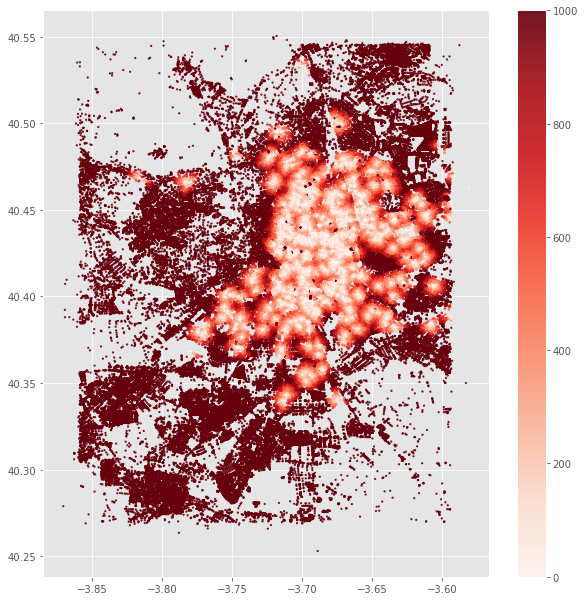

In [133]:
# distance to the nearest amenity of any type
n = 1
fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                            cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Madrid', fontsize=15)
fig.savefig('output/accessibility-Madrid.png', dpi=200, bbox_inches='tight')

In [134]:
# retreive the 5th nearest amenities (of all types) to each node in the network
num_pois = 5
N_nearest_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# returned a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the 5 POIs
print('{:,} nodes'.format(len(N_nearest_access)))

Access_Score = pd.DataFrame(N_nearest_access[5])
Access_Score.head()

166,378 nodes


,5
id,
171946,380.490997
171951,627.158997
171952,545.185974
171953,685.875977
171954,792.812988


#### Network aggregation

Here, we combine `Score`, our compound measure of accessibility (network distance from the node to the 5th nearest POIs) with the POIs dataset `df_pois`.

In [135]:
# We name our measure 'Score'
Access = Access_Score.rename(columns={5:'Score'})
Access.head()
Access.dtypes

Score    float64
dtype: object

Get the nearest `node_id` for each POI, based on its lat-lon

In [136]:
df_pois['node_ids'] = network.get_node_ids(df_pois['Venue Longitude'], df_pois['Venue Latitude'])
df_pois.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,node_ids
1,Palacio,40.415428,-3.713981,Cervecería La Mayor,40.415218,-3.712194,Bar,26213280
4,Palacio,40.415428,-3.713981,Charlie Champagne,40.413936,-3.712647,Restaurant,6471207985
6,Palacio,40.415428,-3.713981,Taberna Rayuela,40.413179,-3.713496,Restaurant,3910906323
11,Palacio,40.415428,-3.713981,la gastroteca de santiago,40.416639,-3.710944,Restaurant,6503522640
13,Palacio,40.415428,-3.713981,Taquería del Alamillo,40.413697,-3.712549,Restaurant,26213513


In [137]:
#pois_sub.reset_index(level=0, inplace=True) # convert index into column
Access.reset_index(level=0, inplace=True)

In [138]:
# Set both columns to have the same names
Access = Access.rename(columns={'id':'node_ids'})
Access.head()

,node_ids,Score
0,171946,380.490997
1,171951,627.158997
2,171952,545.185974
3,171953,685.875977
4,171954,792.812988


In [139]:
# Merging by node_ids
merged = pd.merge(df_pois, Access, on='node_ids')

In [140]:
# Checking column types make sense
merged.dtypes

Neighbourhood               object
Neighbourhood Latitude     float64
Neighbourhood Longitude    float64
Venue                       object
Venue Latitude             float64
Venue Longitude            float64
Venue Category              object
node_ids                     int64
Score                      float64
dtype: object

In [141]:
merged.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,node_ids,Score
0,Palacio,40.415428,-3.713981,Cervecería La Mayor,40.415218,-3.712194,Bar,26213280,295.183990
1,Palacio,40.415428,-3.713981,Charlie Champagne,40.413936,-3.712647,Restaurant,6471207985,187.539993
2,Palacio,40.415428,-3.713981,Taberna Rayuela,40.413179,-3.713496,Restaurant,3910906323,156.623001
3,Palacio,40.415428,-3.713981,la gastroteca de santiago,40.416639,-3.710944,Restaurant,6503522640,256.431000
4,Palacio,40.415428,-3.713981,Taquería del Alamillo,40.413697,-3.712549,Restaurant,26213513,158.897995


<AxesSubplot:>

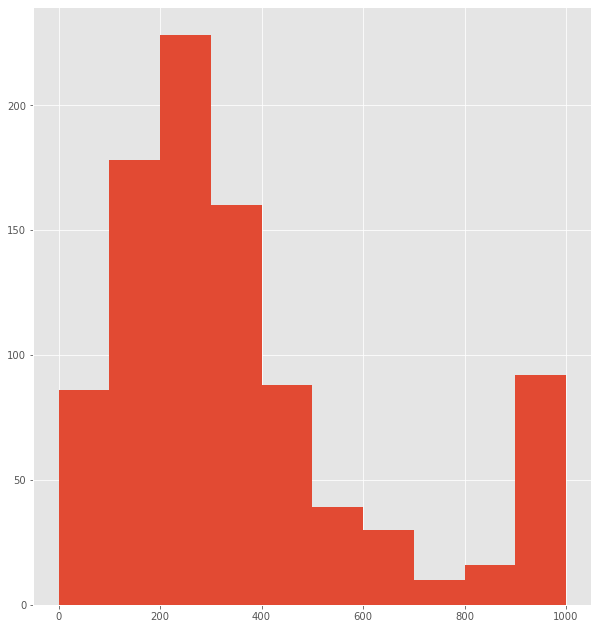

In [142]:
merged['Score'].hist(figsize=(10,11))

In [143]:
# Setting both columns have the same name for merging
df = df.rename(columns={'borough': 'Neighbourhood'})

In [144]:
# Merging by neighbourhoods
df_merged = pd.merge(merged, df, on='Neighbourhood')

In [145]:
# Save cleaned for modelling
df_merged.to_csv(r'output/listings_model.csv', index=id, header=True)

### 6. Preparing data for modelling

#### Dropping columns and assessing multi-collinearity

Categorical variables will now be one-hot encoded:

The accessibility score `Score`(distance to the fifth nearest venue) is now applied to each listing, based on which neighbourhood they belong to. Thus, we no longer need the geographical data or the venue data.

In [146]:
# Open merged dataset for modelling
df_merged = pd.read_csv(r'output/listings_model.csv', index_col=0)
df_merged.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,node_ids,Score,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,host_days_active,air_conditioning,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,smoking_allowed,time_since_first_review,time_since_last_review
0,Palacio,40.415428,-3.713981,Cervecería La Mayor,40.415218,-3.712194,Bar,26213280,295.18399,unknown,unknown,0.0,1.0,0.0,Other,Private room,1,1.0,1.0,1.0,40,0,0,1,0,1,30,0,17,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,0,flexible,3169.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,4+ years,NaN
1,Palacio,40.415428,-3.713981,Cervecería La Mayor,40.415218,-3.712194,Bar,26213280,295.18399,within a few hours,100%,0.0,5.0,1.0,Apartment,Entire home/apt,4,1.0,2.0,3.0,75,500,70,2,10,28,360,0,5,0-79/100,0-8/10,0-8/10,10/10,9/10,10/10,0-8/10,1,strict_14_with_grace_period,3105.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,4+ years,NaN
2,Palacio,40.415428,-3.713981,Cervecería La Mayor,40.415218,-3.712194,Bar,26213280,295.18399,within a few hours,100%,0.0,5.0,1.0,Apartment,Entire home/apt,3,1.0,2.0,2.0,75,500,60,2,10,28,360,0,6,0-79/100,0-8/10,0-8/10,0-8/10,0-8/10,9/10,9/10,1,strict_14_with_grace_period,3105.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,2-3 years,2-6 months
3,Palacio,40.415428,-3.713981,Cervecería La Mayor,40.415218,-3.712194,Bar,26213280,295.18399,within an hour,100%,0.0,1.0,0.0,Apartment,Entire home/apt,6,1.0,2.0,3.0,112,200,89,4,20,2,30,90,205,95-100/100,10/10,9/10,10/10,10/10,10/10,9/10,1,strict_14_with_grace_period,3029.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,4+ years,NaN
4,Palacio,40.415428,-3.713981,Cervecería La Mayor,40.415218,-3.712194,Bar,26213280,295.18399,within an hour,100%,1.0,9.0,1.0,Apartment,Entire home/apt,4,1.0,2.0,1.0,85,100,30,2,10,3,365,56,72,80-94/100,10/10,9/10,10/10,10/10,10/10,9/10,1,strict_14_with_grace_period,3088.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,4+ years,NaN


In [147]:
# Dropping variables no longer needed
df_merged.drop(['Neighbourhood Longitude', 'Venue Latitude', 'Venue Longitude','Neighbourhood Latitude',
               'Venue Category', 'node_ids', 'Venue'], axis=1, inplace=True)

We get dummies for our categorical variables to get the dataset ready for multicollinearity analysis. 

In [148]:
transformed_df = pd.get_dummies(df_merged)
transformed_df.head()

,Score,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,instant_bookable,host_days_active,air_conditioning,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,smoking_allowed,Neighbourhood_Abrantes,Neighbourhood_Acacias,Neighbourhood_Adelfas,Neighbourhood_Aguilas,Neighbourhood_Alameda de Osuna,Neighbourhood_Almagro,Neighbourhood_Almenara,Neighbourhood_Almendrales,Neighbourhood_Aluche,Neighbourhood_Ambroz,Neighbourhood_Amposta,Neighbourhood_Apostol Santiago,Neighbourhood_Arapiles,Neighbourhood_Arcos,Neighbourhood_Argüelles,Neighbourhood_Atocha,Neighbourhood_Bellas Vistas,...,Neighbourhood_Vista Alegre,Neighbourhood_Zofío,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_0-49%,host_response_rate_100%,host_response_rate_50-89%,host_response_rate_90-99%,host_response_rate_unknown,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_checkin_0-8/10,review_scores_checkin_10/10,review_scores_checkin_9/10,review_scores_communication_0-8/10,review_scores_communication_10/10,review_scores_communication_9/10,review_scores_location_0-8/10,review_scores_location_10/10,review_scores_location_9/10,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_0-2 weeks,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months
0,295.18399,0.0,1.0,0.0,1,1.0,1.0,1.0,40,0,0,1,0,1,30,0,17,0,3169.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,295.18399,0.0,5.0,1.0,4,1.0,2.0,3.0,75,500,70,2,10,28,360,0,5,1,3105.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,295.18399,0.0,5.0,1.0,3,1.0,2.0,2.0,75,500,60,2,10,28,360,0,6,1,3105.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0
3,295.18399,0.0,1.0,0.0,6,1.0,2.0,3.0,112,200,89,4,20,2,30,90,205,1,3029.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
4,295.18399,1.0,9.0,1.0,4,1.0,2.0,1.0,85,100,30,2,10,3,365,56,72,1,3088.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0


We now assess for multicollinearity of features:

In [149]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

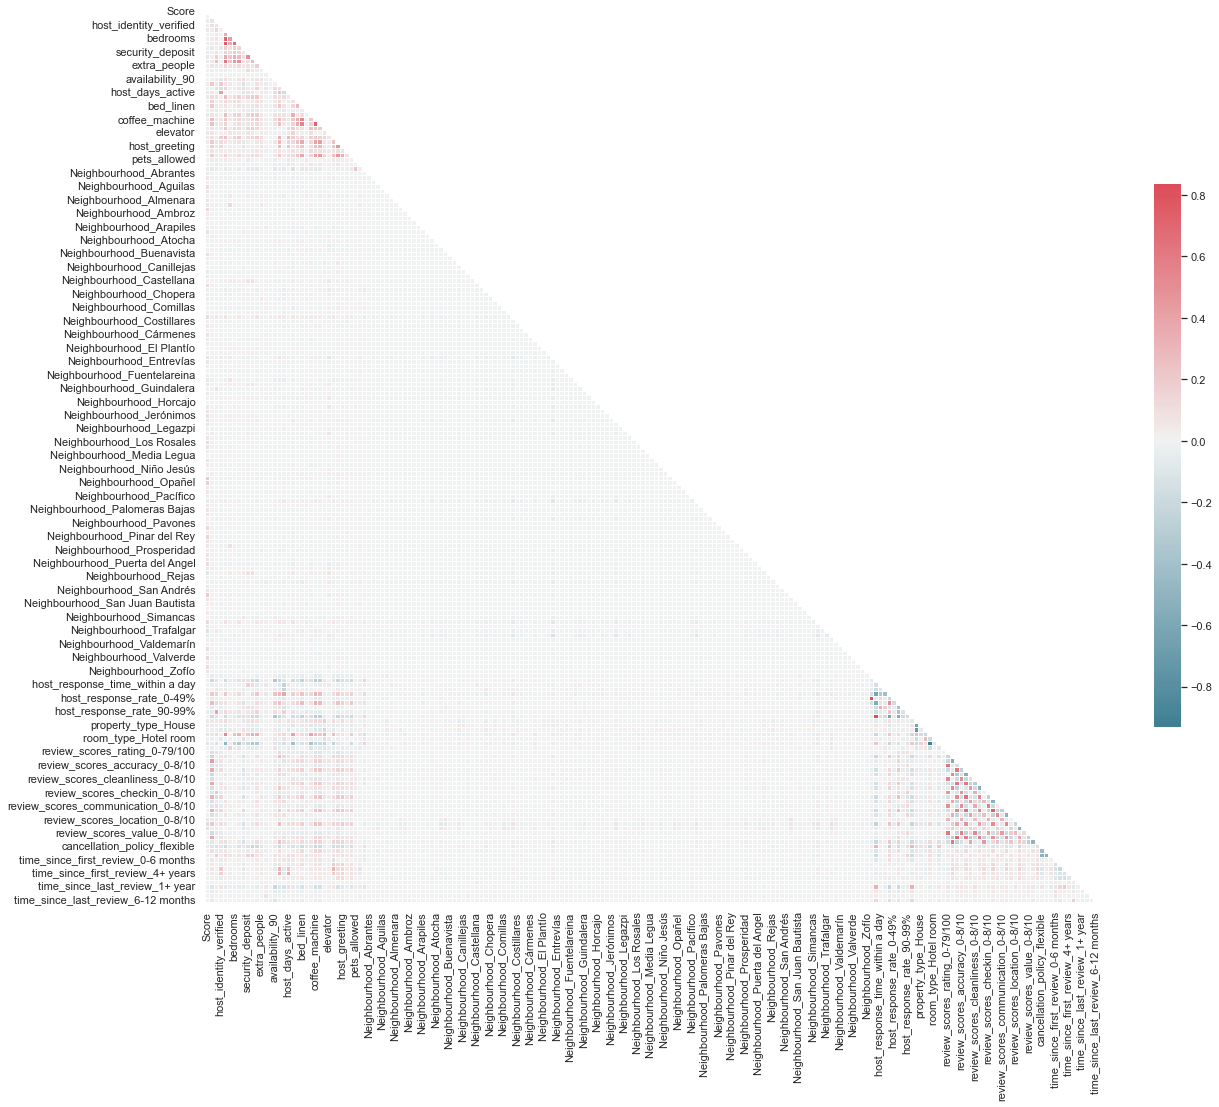

In [150]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

It doesn't look like there are any significant collinear relationships with neighbourhood variables, so these will temporarily be dropped to produce a clearer heatmap for the remaining features:

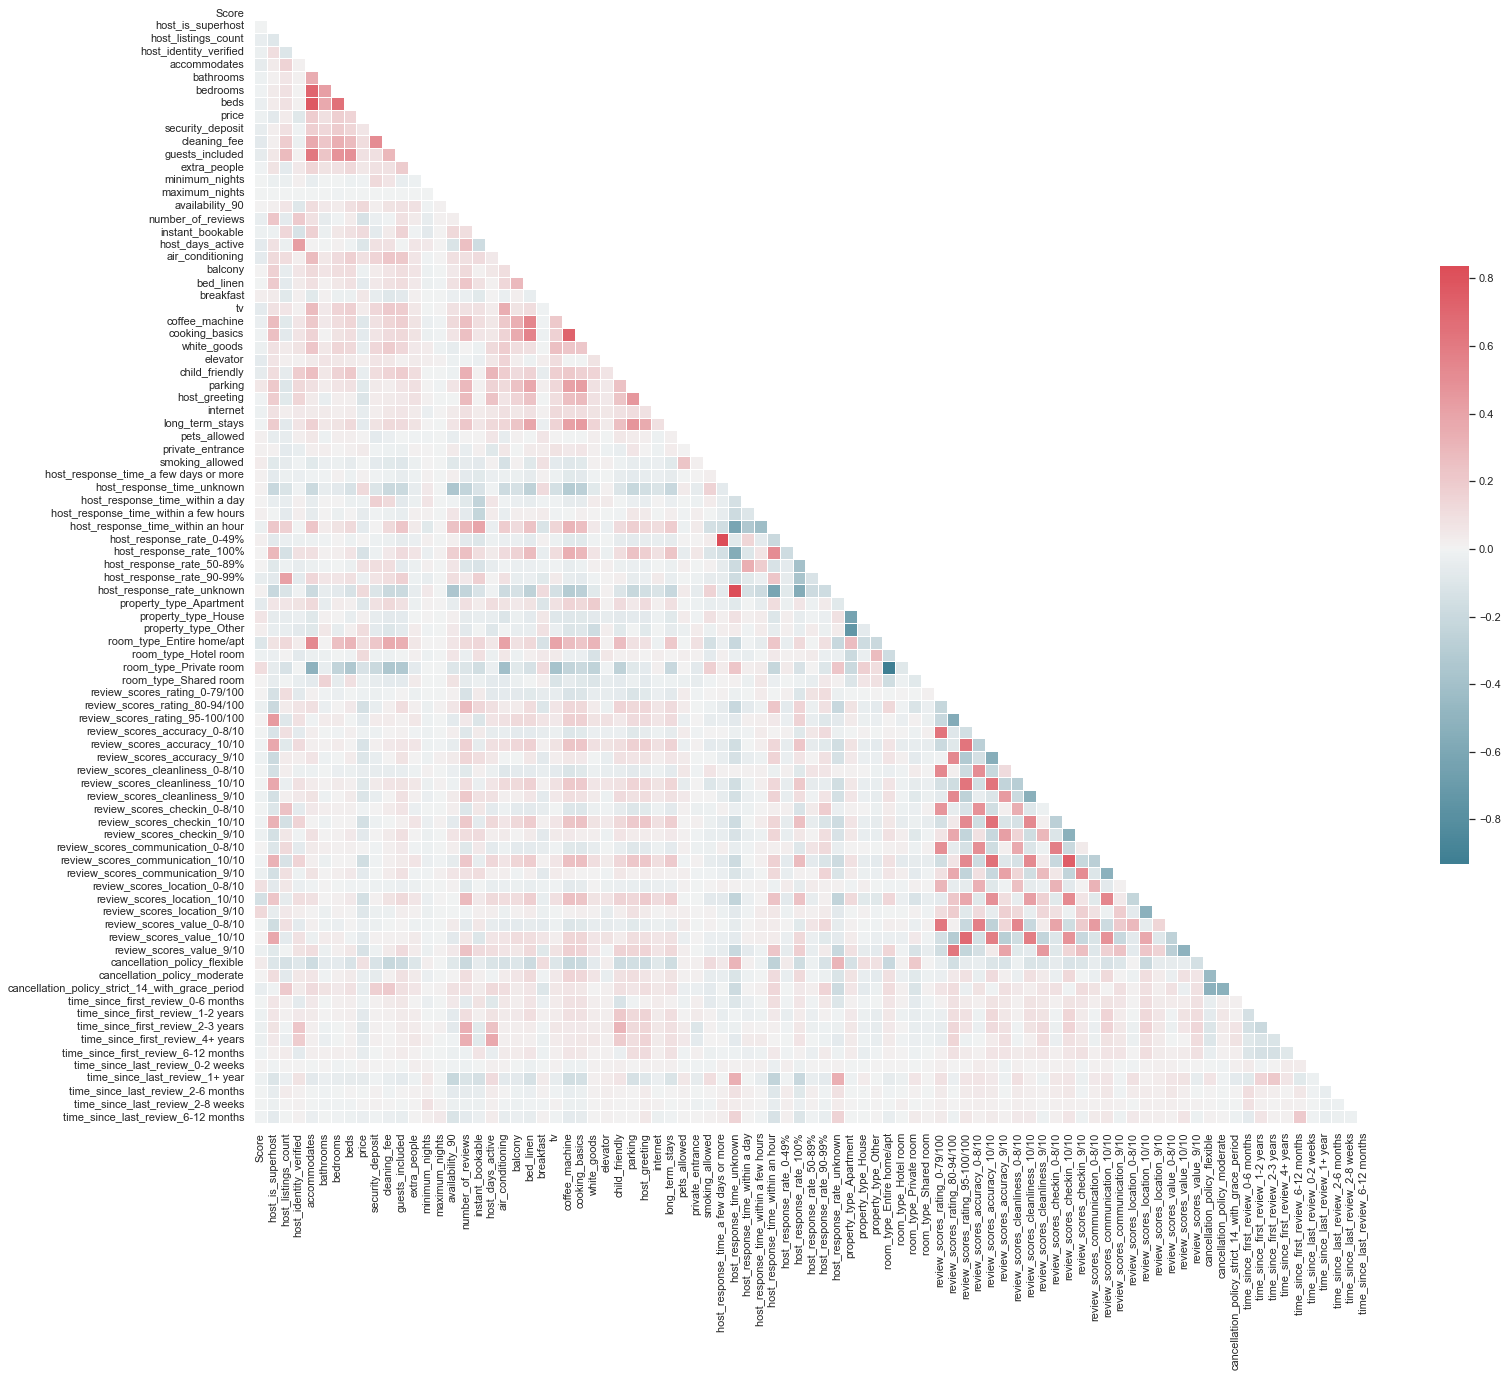

In [151]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('Neighbourhood')]), axis=1), figsize=(25,22))

Areas of multi-collinearity:

- `Beds`, `bedrooms`, `guests_included` and the number of people that a property `accommodates` are highly correlated. The number of people accommodated has traditionally been a more high priority search parameter on Airbnb, as it is more relevant for private and shared rooms than the number of bedrooms (and is still the second highest priority parameter when searching on the site, after dates.

- Unsurprisingly, there are perfect correlations between `NaN reviews` (i.e. listings that are not reviewed yet) for different review categories, and first and last review times. `NaN` categories can therefore be dropped.

- The same is true of `host_response_rate_unknown` and `host_response_time_unknown`. One of these rates will be dropped.

- There is a correlation between `host_response_rate 0-49%` and `host_response_time_a few days or more`. One of these will be dropped.

- There are strong negative correlations between `property_type_House` and `property_type_Apartment`, and between `room_type_Private room` and `room_type_Entire_home_apt` (as these were the main two categories of their features before they were one-hot encoded). Although these are important categories, one of each will be dropped in order to reduce multi-collinearity (apartments and private rooms, as these are the second most common categories).

In [152]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

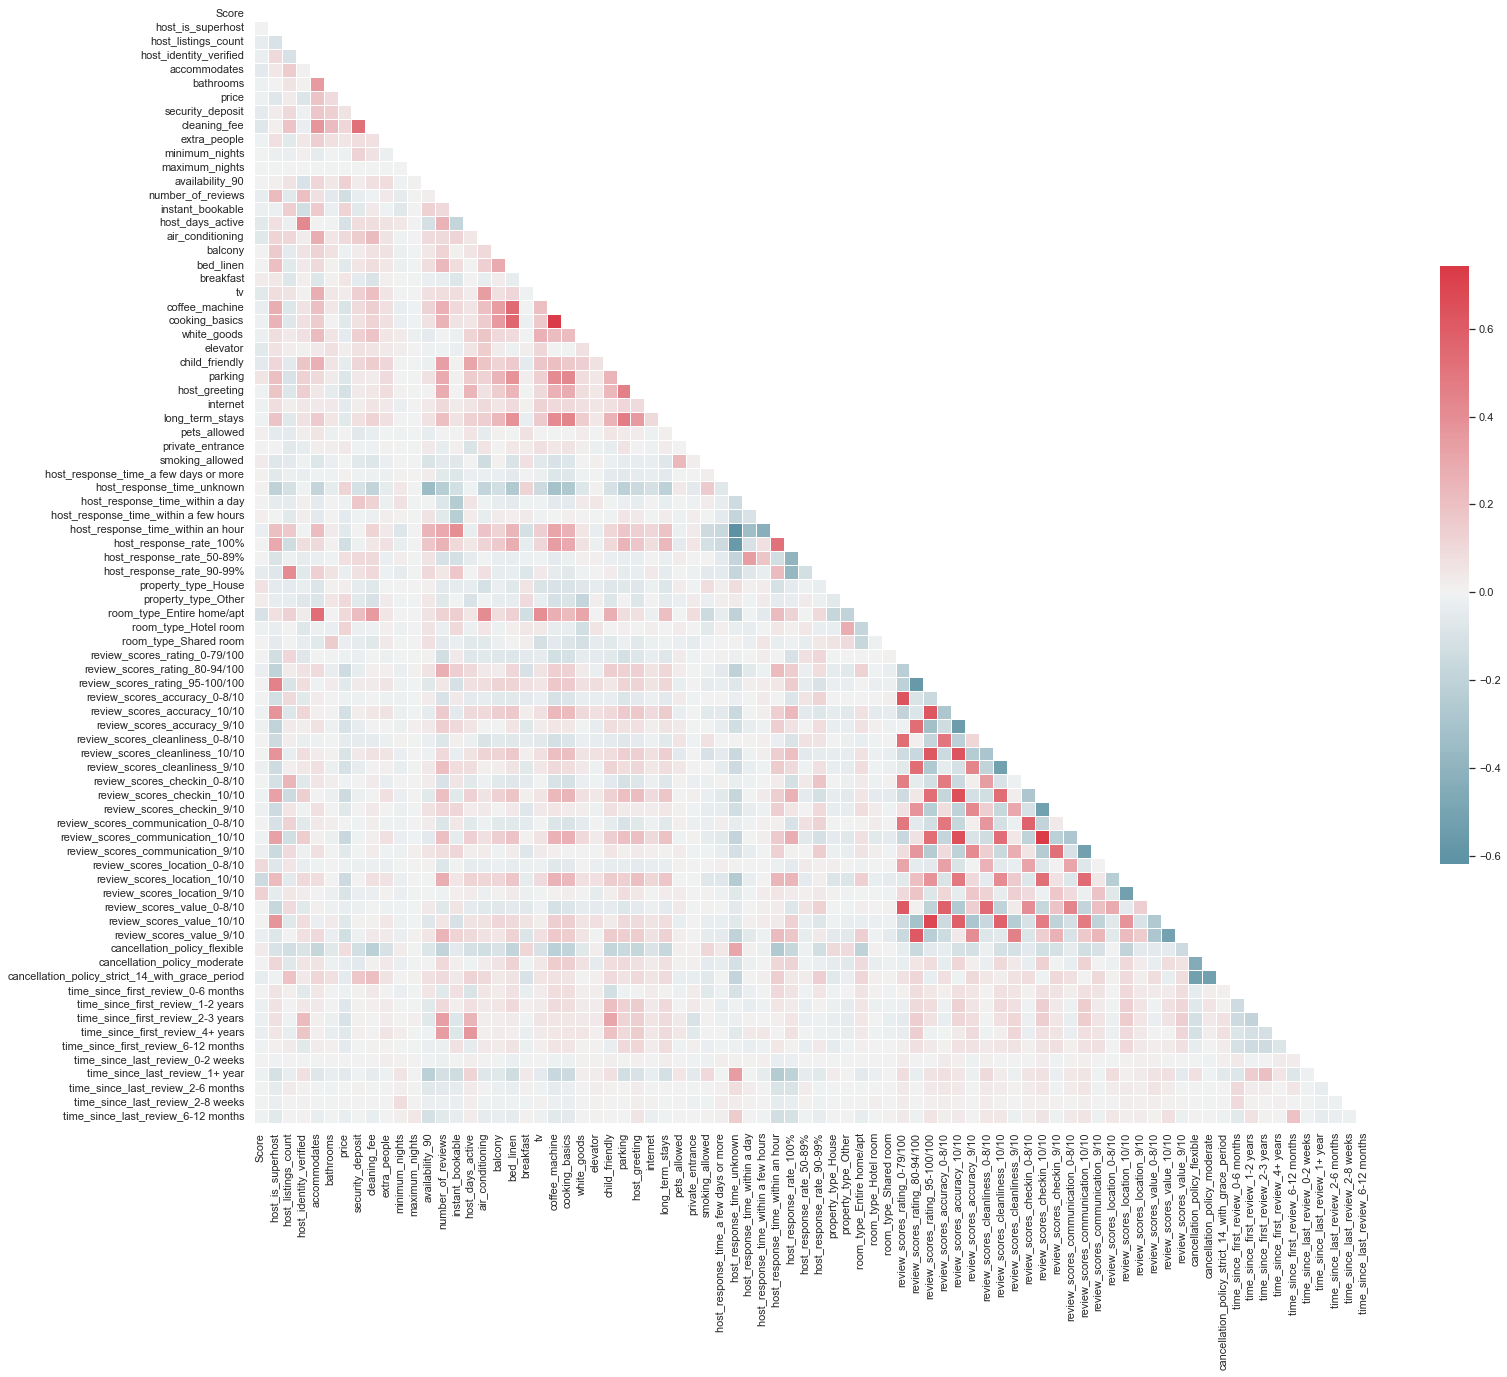

In [153]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('Neighbourhood')]), axis=1), figsize=(25,22))

There are still some fairly strong correlations between highly rated properties of different reviews categories - i.e. if a property gets a 10/10 for one category, it is likely to get a 10/10 for other categories. However, these will be left in for now and can be experimented with later to see if removing them improves the model.

#### Standardising and normalising

Other than `availability_90` and `host_days_active`, the remaining numerical features are all postively skewed and could benefit from log transformation.

In [154]:
numerical_columns = ['Score','accommodates', 'availability_90', 'bathrooms',
                     'cleaning_fee', 'extra_people', 'host_days_active', 
                     'host_listings_count', 'maximum_nights', 'minimum_nights', 
                     'number_of_reviews', 'price', 'security_deposit']

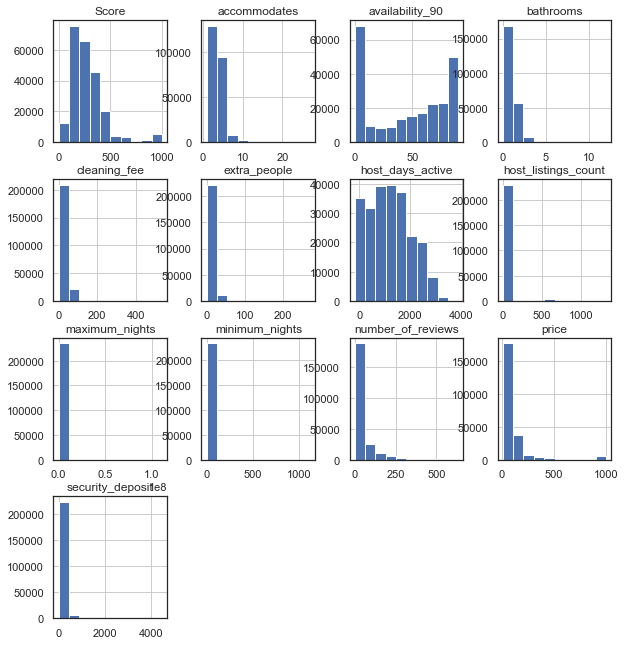

In [155]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [156]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns 
                     if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

This appears to have helped some of the distributions, although some (e.g. `cleaning_fee`, `extra_people` fee and `security_fee`) contain a large number of 0s, which means these features are not normally distributed. Most importantly, however, the target variable price now appears much more normally distributed.

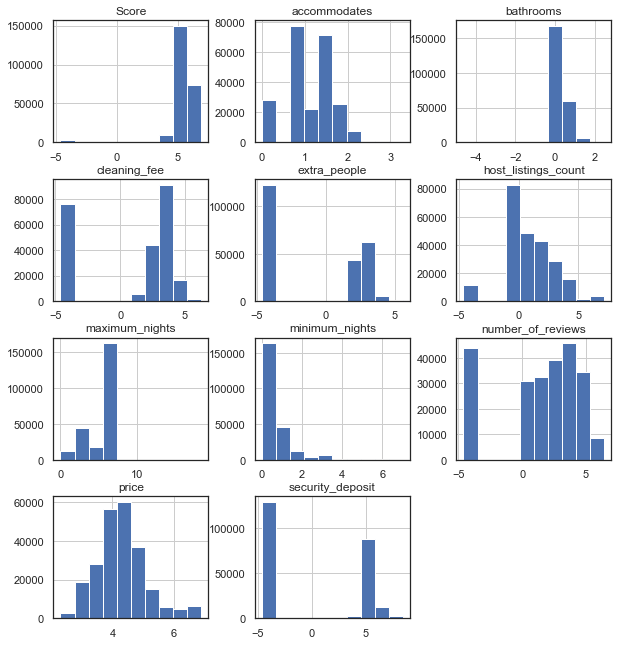

In [157]:
transformed_df[numerical_columns].hist(figsize=(10,11));

Finally, the predictive features `X` and the target feature `y` can be separated, and `X` will be scaled. `StandardScaler` from `sklearn` will be used, but the type of scaling used could be experimented with later to see if alternative versions yield better results.

That is, we’ll separate the features and the target variable for modeling. We will assign the features (explanatory variables) to `X` and the target variable to `y`. We use `scaler.fit_transform()`, as mentioned above, to transform the `y` variable for the model. `transformed_df.drop([features], axis=1)` tells pandas which columns we want to exclude. We won’t include `price` for obvious reasons, and `ID` is just an index with no relationship to `price`.

In [158]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

### 7. Modelling

Now that the data preprocessing is over, we can start applying different Supervised Machine Learning models. We will compare two models:

- A **Spatial Hedonic Price Model** (OLS Regression), with the `LinearRegression` from Scikit-Learn library
- The **Gradient Boosting method**, with the `XGBRegressor` from the XGBoost library

The evaluation metrics used will be mean squared error (for loss) and r-squared (for accuracy).

In [159]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) 

#### Model 1: Spatial Hedonic Price Model (HPM)

The hedonic model involves regressing observed asking-prices for the listing against those attributes of a property hypothesized to be determinants of the asking-price. It comes from **hedonic price theory** which assumes that a commodity, such as a house can be viewed as an aggregation of individual components or attributes.
In addition to the characteristics of the Airbnb listings, we add location features as they have been shown to be important factors in influencing the price. Ideally, Lagrange multiplier tests should be conducted to verify if there is spatial lag in the dependent variable and therefore a spatial lag model is preferred for estimating a spatial HPM. However, for the purposes of this post, we are only using a conventional OLS model for hedonic price estimation that includes spatial and locational features, but not a spatial lag that accounts for spatial dependence.

So, the first explanatory variables are the listings characteristics (`acommodates`, `bathrooms`, etc) and our second group of explanatory variables based on spatial and locational features are `Score`, which is the network distance to 5th nearest venue we computed with Pandana; and `Neighbourhood` belonging, `1` if the listing belongs to the specified neighbourhood, `0` otherwise.

In [160]:
hpm_reg_start = time.time()

# Create instance of the model, `LinearRegression` function from 
# Scikit-Learn and fit the model on the training data:

hpm_reg = LinearRegression()  
hpm_reg.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling 
# the predict command. We are making predictions on the testing set:
training_preds_hpm_reg = hpm_reg.predict(X_train)
val_preds_hpm_reg = hpm_reg.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg),4))

Time taken to run: 0.0 minutes

Training RMSE: 0.3615
Validation RMSE: 0.3607

Training r2: 0.4735
Validation r2: 0.4762


This means that our features explain approximately 50% of the variance in our target variable. 

Interpreting the  ` mean_squared_error`value is somewhat more intuitive that the r-squared value. The RMSE measures the distance between our predicted values and actual values.

We can compare the actual output values for `X_test` with the predicted values in a dataframe:

In [161]:
y_test_array = np.array(list(y_test))
val_preds_hpm_reg_array = np.array(val_preds_hpm_reg)
hpm_df = pd.DataFrame({'Actual': y_test_array.flatten(), 'Predicted': val_preds_hpm_reg_array.flatten()})
hpm_df

,Actual,Predicted
0,3.610918,3.848490
1,4.317488,4.454284
2,4.828314,4.836044
3,4.499810,4.580770
4,4.828314,4.614173
...,...,...
46988,4.700480,4.459457
46989,2.772589,3.618042
46990,4.912655,4.642171
46991,3.806662,3.363342


And we can view this relationship graphically with a scatter plot:

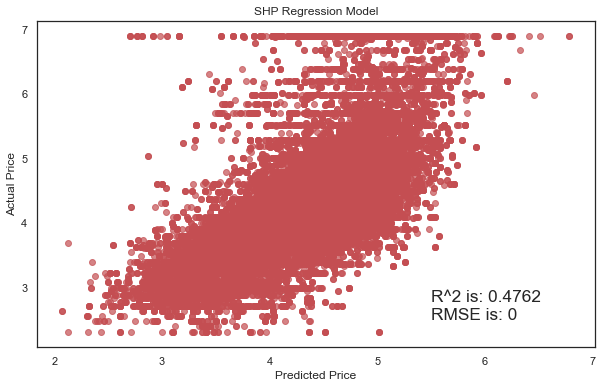

In [162]:
actual_values = y_test
plt.scatter(val_preds_hpm_reg, actual_values, alpha=.7,
            color='r') #alpha helps to show overlapping data
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    (round(r2_score(y_test, val_preds_hpm_reg),4)),
                    (round(mean_squared_error(y_test, val_preds_hpm_reg))),4)
plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SHP Regression Model')
plt.show()

If our predicted values were identical to the actual values, this graph would be the straight line `y=x` because each predicted value x would be equal to each actual value y.

##### Improving our model

We can try using Ridge Regularization to decrease the influence of less important features. Ridge Regularization is a process which shrinks the regression coefficients of less important features.

We’ll once again instantiate the model. The Ridge Regularization model takes a parameter, alpha , which controls the strength of the regularization.

We’ll experiment by looping through a few different values of alpha, and see how this changes our results.

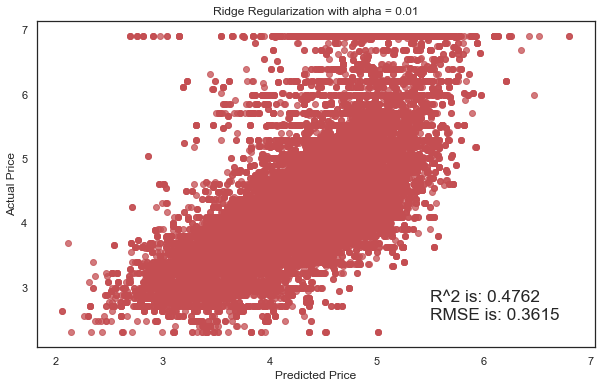

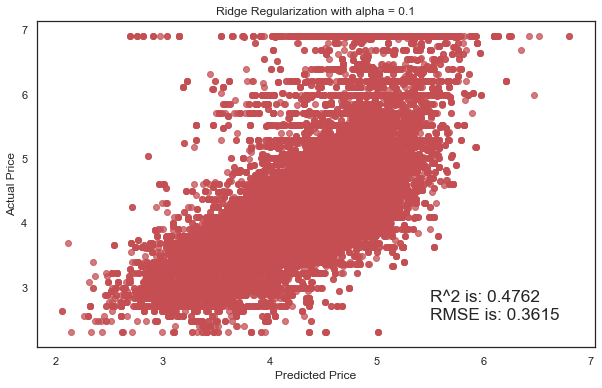

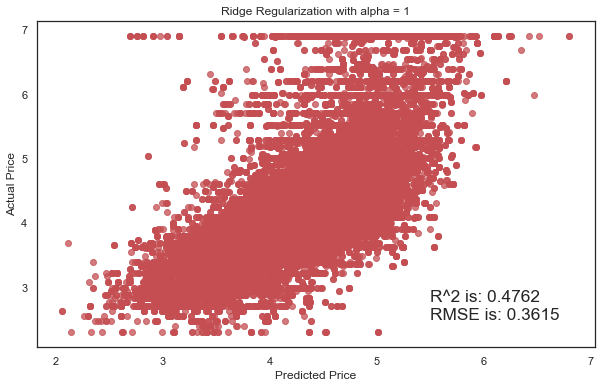

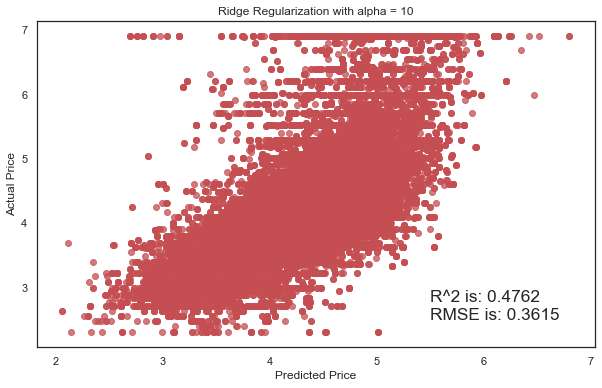

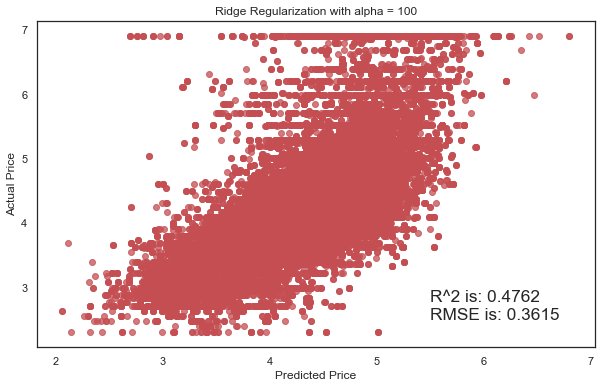

In [163]:
lr = linear_model.LinearRegression()

for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)

    plt.scatter(preds_ridge, actual_values, alpha=.75, color='r')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                   round(ridge_model.score(X_test, y_test), 4),
                    round(mean_squared_error(y_train, training_preds_hpm_reg),4))
    plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
    plt.show()

These models perform almost identically to the first model. In our case, adjusting the alpha did not substantially improve our model. 

#### Model 2:  Gradient boosted decision trees

Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. A popular example is the AdaBoost algorithm that weights data points that are hard to predict.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

This model will most likely provide the best achievable accuracy and a measure of feature importance compared to our Hedonic regression (other than possible small accuracy increases from hyper-parameter tuning) due to XGBoost's superior performance.

In [164]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.4 minutes

Training MSE: 0.0918
Validation MSE: 0.0958

Training r2: 0.8663
Validation r2: 0.8609


This means that our features explain approximately 87% of the variance in our target variable. 

##### Feature importance

Apart from its superior performance, a benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.


In [165]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

,weight
room_type_Entire home/apt,0.243803
host_response_time_unknown,0.068066
room_type_Hotel room,0.054768
bathrooms,0.031493
host_response_rate_50-89%,0.027369
room_type_Shared room,0.023023
air_conditioning,0.021803
accommodates,0.016707
number_of_reviews,0.016561
host_response_rate_90-99%,0.015889


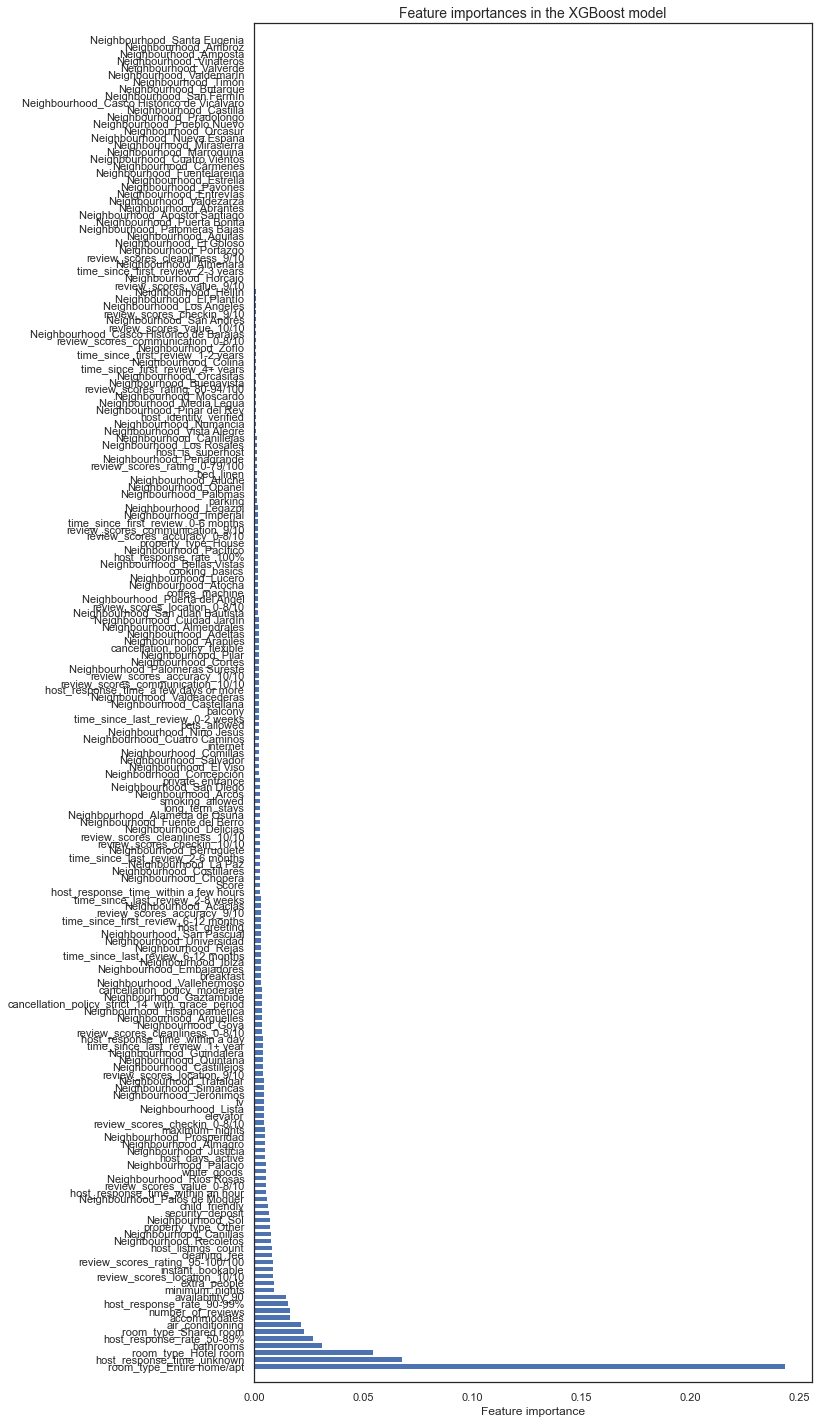

In [166]:
# Plotting feature importances
plt.figure(figsize=(10,25))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

About a good number of features have a feature importance of 0 in this XGBoost regression model, and could potentially be removed.

The top 10 most important features are:

1. If the rental is the entire flat or not `room_type_Entire home/apt`
2. How many people the property accommodates (`accommodates`)
3. The type of property (`property_type_Other`)
4. The number of bathrooms (`bathrooms`)
5. How many days are available to book out of the next 90 (`availability_90`)
6. The number of reviews (`number_of_reviews`)
7. The cancellation policy being moderate (`cancellation_policy_moderate`)
8. How many other listings the host has (`host_listings_count`)
9. The minimum night stays (`minimum_nights`)
10. The maximum nights stay (`maximum_nights`)

The most important features the rental being the entire flat. Which makes sense. Asking price is higher if the offer is for the entire flat/house. This could also suggest that offering the flat/house as a whole, rather than each bedroom individually, may be better overall, given the large difference in importance compared to the second most important feature.

It is not surprising that the second how many people the property accommodates, as that's one of the main things you would use to search for properties with in the first place.

It is perhaps more surprising that location features did not appear in the top ten. Although we can observe that belonging to a certain neighbourhood increases price more than others and `Score` (accessibility measure) also shows some importance, they are of relative low importance compared to the top 3 features. `Review Scores Location` is higher on the importance list (number 11). This is, it is likely renters put more weight in other's opinion about location instead of judging the location based on neighbourhood and venues around the property. This could also be because Madrid is a small and walkable city with good transportation services. Thus, location is not a major problem to reaching main touristic attractions and amenities.


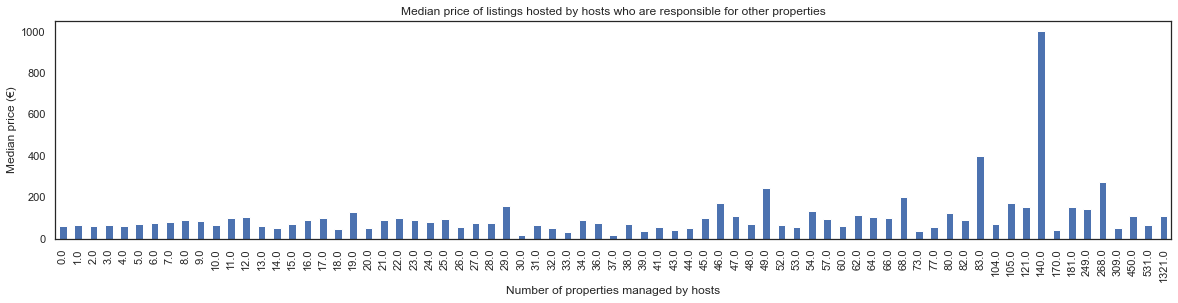

In [167]:
# Median price for different host listing counts
plt.figure()
df_merged.groupby('host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price (€)');

#### Improving models

In the 'Preparing the data for modeling' section above, it was noted that a lot of the review columns are reasonably highly correlated with each other. They were left in to see whether they would be useful after all. However, the feature importances graph produced by the XGBoost model suggest that they were of relatively low importance.

This model will drop review columns other than the overall review rating, and use the same Hedonic regression and XGBoost structure, in order to see whether this produces a better models.

Columns will be dropped from the existing `X_train` and `X_test` split, for consistency.

In [168]:
all_review = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
review_to_keep = list(X_train.columns[X_train.columns.str.startswith("review_scores_rating")])
review_to_drop = [x for x in all_review if x not in review_to_keep]

X_train_short = X_train.drop(review_to_drop, axis=1)
X_test_short = X_test.drop(review_to_drop, axis=1)

#### Model 3: Hedonic regression with dropped columns

In [169]:
hpm_reg_start = time.time()

# Create instance of the model, `LinearRegression` function from 
# Scikit-Learn and fit the model on the training data:

hpm_reg2 = LinearRegression()  
hpm_reg2.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling 
# the predict command. We are making predictions on the testing set:
training_preds_hpm_reg2 = hpm_reg2.predict(X_train)
val_preds_hpm_reg2 = hpm_reg2.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg2),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg2),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg2),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg2),4))

Time taken to run: 0.0 minutes

Training RMSE: 0.3615
Validation RMSE: 0.3607

Training r2: 0.4735
Validation r2: 0.4762


#### Model 4: XG Boost with dropped columns

In [170]:
xgb_reg_start = time.time()

xgb_reg2 = xgb.XGBRegressor()
xgb_reg2.fit(X_train, y_train)
training_preds_xgb_reg2 = xgb_reg2.predict(X_train)
val_preds_xgb_reg2 = xgb_reg2.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg2),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg2),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg2),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg2),4))

Time taken to run: 0.4 minutes

Training MSE: 0.0918
Validation MSE: 0.0958

Training r2: 0.8663
Validation r2: 0.8609


Both Spatial Hedonic Regression and XGBoost perform almost exactly the same without the additional review columns.

Hence, because they are able to achieve the same performance with 18 fewer columns, the second models are the preferred models as they require less data and are less computationally expensive.

#### Final model selection

Overall, the XGBoost model (Model 4) is the preferred model, which performs better than both Spatial Hedonic Regression Models and just as good as the first model but is less computationally expensive. It could possibly be improved further with hyper-parameter tuning.

### Conclusions and Recommendations

The best performing model was able to predict 86.63% of the variation in price with an RMSE of 0.09. Which means we still have a remaining 13.36% unexplained. This could be due to several other features that are not part of our dataset or the need to analyse our features more closely.

For example, given the importance of customer reviews of the listing in determining price, perhaps a better understanding of the reviews could improve the prediction. Using Sentiment Analysis, a score between -1 (very negative sentiment) and 1 (very positive sentiment) can be assigned to each review per listing property. The scores are then averaged across all the reviews associated with that listing and the final scores can be included as a new feature in the model (see [here](https://arxiv.org/pdf/1907.12665.pdf) for an example).

Another suggestion is the inclusion of image quality as a feature. Using Difference-in-Difference deep learning and supervised learning analyses on a Airbnb panel dataset, researchers found that units with verified photos (taken by Airbnb’s photographers) generate additional revenue per year on average ([see here](https://poseidon01.ssrn.com/delivery.php?ID=204024105119026094069105008103096093034021070051045032025117103105027080085099113011048103001010014121023024085079004082003114107082070089028074094097015117086091125049040024103012093025001119016069070080070120120094005077005088015116003064009008121126&EXT=pdf)). 

It was noticeable that reviews about listing location, rather than the location features themselves, were higher in the feature importance list. Thus, this finding could perhaps be used by Airbnb hosts when writing their listing's description. Highlighting accessibility and location benefits of staying with them could perhaps benefit them and how much they can ask for their listing. 